# Computer Vision Applications - Part II: Feature Detection and Face Analysis

## Table of Contents
- [1. Feature Detection and Description](#1-feature)
- [2. Corner Detection Algorithms](#2-corner)
  - [2.1 Harris Corner Detector](#2-1-harris)
  - [2.2 Shi-Tomasi Corner Detector](#2-2-shi-tomasi)
  - [2.3 FAST Detector](#2-3-fast)
  - [2.4 Algorithm Comparison](#2-4-comparison)
- [3. Feature Description and Matching](#3-matching)
  - [3.1 Feature Descriptors](#3-1-descriptors)
  - [3.2 Feature Matching](#3-2-matching)
  - [3.3 Improving Matches with RANSAC](#3-3-ransac)
- [4. Face Detection with OpenCV and Haar Cascades](#4-face)
  - [4.1 Understanding Haar Cascades](#4-1-haar)
  - [4.2 Implementing Face Detection](#4-2-implementation)
  - [4.3 Handling Detection Challenges](#4-3-challenges)
  - [4.4 Improving Detection with Preprocessing](#4-4-preprocessing)
- [5. Facial Landmark Detection](#5-landmarks)
  - [5.1 What are Facial Landmarks?](#5-1-what)
  - [5.2 Detecting Facial Landmarks](#5-2-detecting)
  - [5.3 Applications of Facial Landmarks](#5-3-applications)
- [6. Exercise: Interactive Exploration](#6-exercise)
- [7. Conclusion](#7-conclusion)

## Introduction to Image Processing and Computer Vision

## Introduction

This notebook covers essential computer vision techniques:
- Feature detection, description, and matching
- Corner detection algorithms
- Face detection with Haar cascades
- Facial landmark detection


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
from IPython.display import display, Image

# Set up Matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

## 1. Feature Detection and Description

### What are Features?

Features in computer vision are distinctive, interesting points or regions in an image that provide valuable information for tasks like image matching, object recognition, and tracking.

**Types of Features:**
- **Corners**: Points where two edges intersect
- **Edges**: Boundaries between different regions
- **Blobs**: Regions with different properties than surroundings
- **Ridges**: Elongated regions with specific width properties

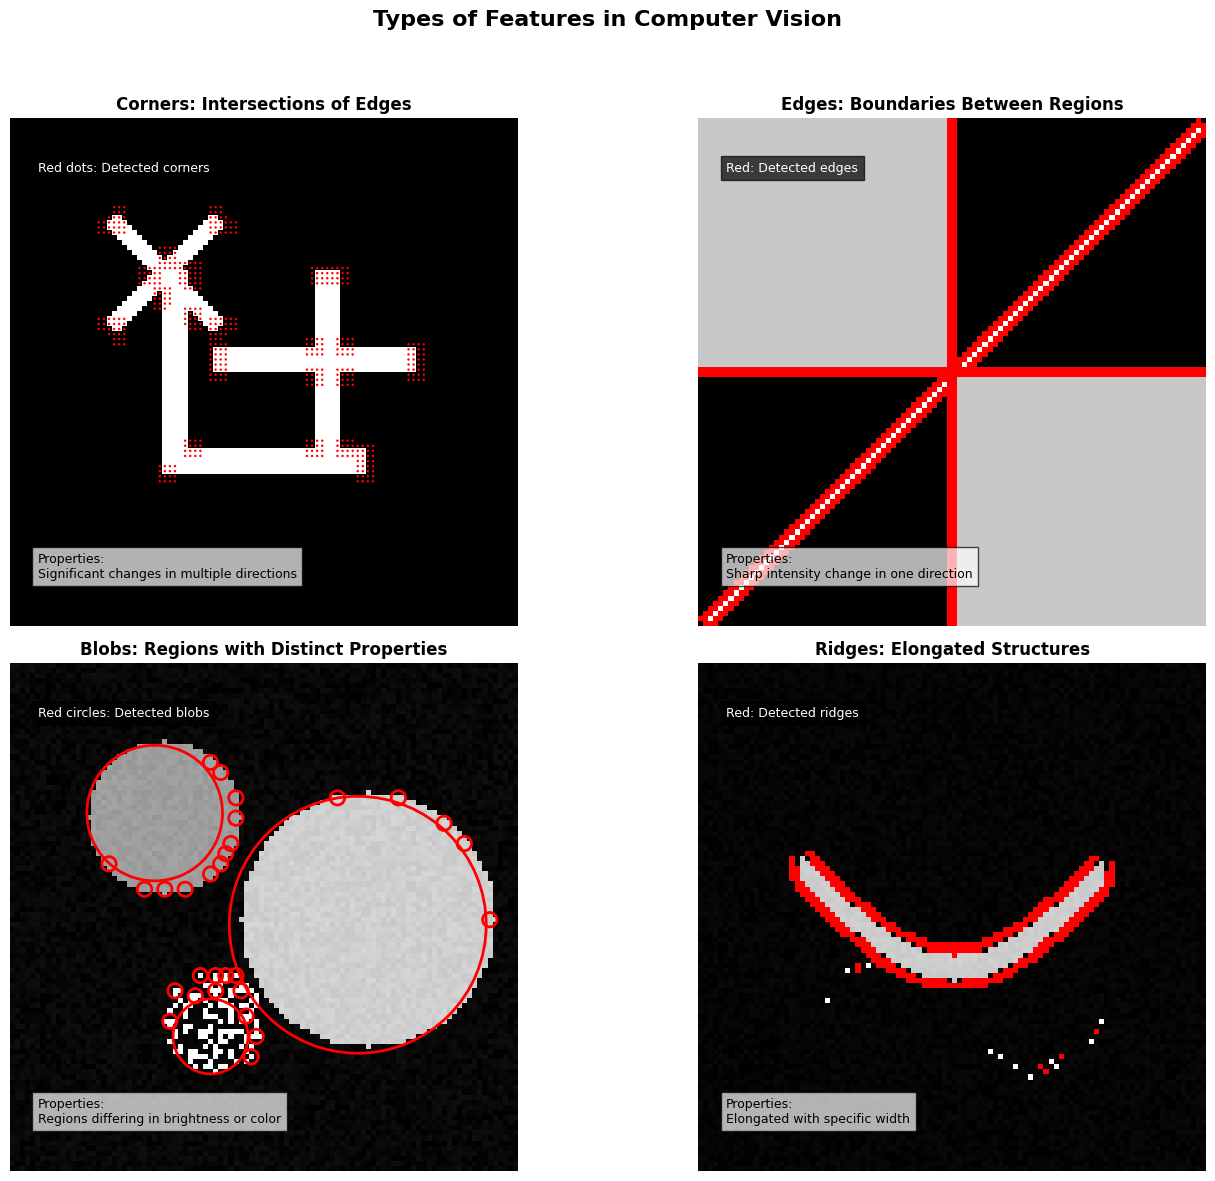

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Circle
from skimage import feature
from skimage.filters import frangi

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Types of Features in Computer Vision', fontsize=16, fontweight='bold')

#----------------------------------------------------------------------------
# 1. CORNERS: Top-left subplot (0,0)
#----------------------------------------------------------------------------
axs[0, 0].set_title('Corners: Intersections of Edges', fontweight='bold')
# Synthetic image with different junctions
corner_img = np.zeros((100, 100), dtype=np.uint8)
# L-shaped corner
corner_img[30:70, 30:35] = 255  
corner_img[65:70, 30:70] = 255  
# T-junction
corner_img[30:70, 60:65] = 255  
corner_img[45:50, 40:80] = 255  
# X-junction
cv2.line(corner_img, (20, 20), (40, 40), 255, 2)
cv2.line(corner_img, (20, 40), (40, 20), 255, 2)

# Detect corners
corner_img_float = corner_img.astype(np.float32) / 255.0
harris_response = cv2.cornerHarris(corner_img_float, blockSize=2, ksize=3, k=0.04)
harris_response = cv2.dilate(harris_response, None)

axs[0, 0].imshow(corner_img, cmap='gray')

# Overlay detected corners in red with reduced dot size
thresh = 0.01 * harris_response.max()
ys, xs = np.where(harris_response > thresh)
for x, y in zip(xs, ys):
    axs[0, 0].add_patch(Circle((x, y), radius=0.1, color='red'))  # Reduced radius to 0.1

axs[0, 0].text(5, 10, "Red dots: Detected corners", color='white',
        bbox=dict(facecolor='black', alpha=0.7), fontsize=9)
axs[0, 0].text(5, 90, "Properties:\nSignificant changes in multiple directions", 
        color='black', bbox=dict(facecolor='white', alpha=0.7), fontsize=9)
axs[0, 0].axis('off')

#----------------------------------------------------------------------------
# 2. EDGES: Top-right subplot (0,1)
#----------------------------------------------------------------------------
axs[0, 1].set_title('Edges: Boundaries Between Regions', fontweight='bold')
edge_img = np.zeros((100, 100), dtype=np.uint8)
# Two regions with a sharp boundary
edge_img[:50, :50] = 200  
edge_img[50:, 50:] = 200  
# Diagonal edge
for i in range(100):
    if 0 <= 100-i < 100:
        edge_img[i, 100-i] = 255

# Apply Sobel filter
sobel_x = cv2.Sobel(edge_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(edge_img, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_mag = (sobel_mag / sobel_mag.max() * 255).astype(np.uint8)

# Create an overlay of edges in red
edge_rgb = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2RGB)
edge_mask = sobel_mag > 50
edge_rgb[edge_mask] = [255, 0, 0]

axs[0, 1].imshow(edge_rgb)
axs[0, 1].text(5, 10, "Red: Detected edges", color='white',
        bbox=dict(facecolor='black', alpha=0.7), fontsize=9)
axs[0, 1].text(5, 90, "Properties:\nSharp intensity change in one direction", 
        color='black', bbox=dict(facecolor='white', alpha=0.7), fontsize=9)
axs[0, 1].axis('off')

#----------------------------------------------------------------------------
# 3. BLOBS: Bottom-left subplot (1,0)
#----------------------------------------------------------------------------
axs[1, 0].set_title('Blobs: Regions with Distinct Properties', fontweight='bold')
blob_img = np.zeros((100, 100), dtype=np.uint8)
cv2.circle(blob_img, (30, 30), 15, 150, -1)
cv2.circle(blob_img, (70, 50), 25, 200, -1)
cv2.circle(blob_img, (40, 70), 10, 250, -1)
# Add mild noise
blob_img = blob_img + np.random.randint(0, 15, size=blob_img.shape, dtype=np.uint8)

blobs = feature.blob_log(blob_img, min_sigma=1, max_sigma=20, threshold=0.1)

axs[1, 0].imshow(blob_img, cmap='gray')
for blob in blobs:
    y, x, sigma = blob
    radius = sigma * np.sqrt(2)
    axs[1, 0].add_patch(Circle((x, y), radius, edgecolor='red', fill=False, linewidth=2))

axs[1, 0].text(5, 10, "Red circles: Detected blobs", color='white',
        bbox=dict(facecolor='black', alpha=0.7), fontsize=9)
axs[1, 0].text(5, 90, "Properties:\nRegions differing in brightness or color", 
        color='black', bbox=dict(facecolor='white', alpha=0.7), fontsize=9)
axs[1, 0].axis('off')

#----------------------------------------------------------------------------
# 4. RIDGES: Bottom-right subplot (1,1)
#----------------------------------------------------------------------------
axs[1, 1].set_title('Ridges: Elongated Structures', fontweight='bold')
ridge_img = np.zeros((100, 100), dtype=np.uint8)
# Create two curved ridges
for i in range(20, 80):
    y = int(40 + 20 * np.sin((i - 20) / 60 * np.pi))
    for t in range(-2, 3):
        if 0 <= y+t < 100:
            ridge_img[y+t, i] = 200
for i in range(20, 80):
    y = int(70 - 10 * np.sin((i - 20) / 30 * np.pi))
    for t in range(-1, 2):
        if 0 <= y+t < 100:
            ridge_img[y+t, i] = 255
ridge_img = ridge_img + np.random.randint(0, 10, size=ridge_img.shape, dtype=np.uint8)

# Apply Frangi filter to highlight ridge structures
ridge_response = frangi(ridge_img.astype(float))
norm_response = ((ridge_response - ridge_response.min()) / 
                (ridge_response.max() - ridge_response.min()) * 255).astype(np.uint8)
ridge_mask = norm_response > 0.2 * norm_response.max()

ridge_rgb = cv2.cvtColor(ridge_img, cv2.COLOR_GRAY2RGB)
ridge_rgb[ridge_mask] = [255, 0, 0]

axs[1, 1].imshow(ridge_rgb)
axs[1, 1].text(5, 10, "Red: Detected ridges", color='white',
        bbox=dict(facecolor='black', alpha=0.7), fontsize=9)
axs[1, 1].text(5, 90, "Properties:\nElongated with specific width", 
        color='black', bbox=dict(facecolor='white', alpha=0.7), fontsize=9)
axs[1, 1].axis('off')

# Show the figure with tight layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('feature_types.png', dpi=300, bbox_inches='tight')
plt.show()


**Properties of Good Features:**
- Repeatable: Can be found in different images of the same scene
- Distinctive: Unique appearance
- Local: Depend only on a small area
- Numerous: Many can be found in typical images
- Accurate: Precisely localized
- Efficient: Quick to compute

In [5]:
# Load a sample image
sample_img = cv2.imread('images/coins01.jpg')

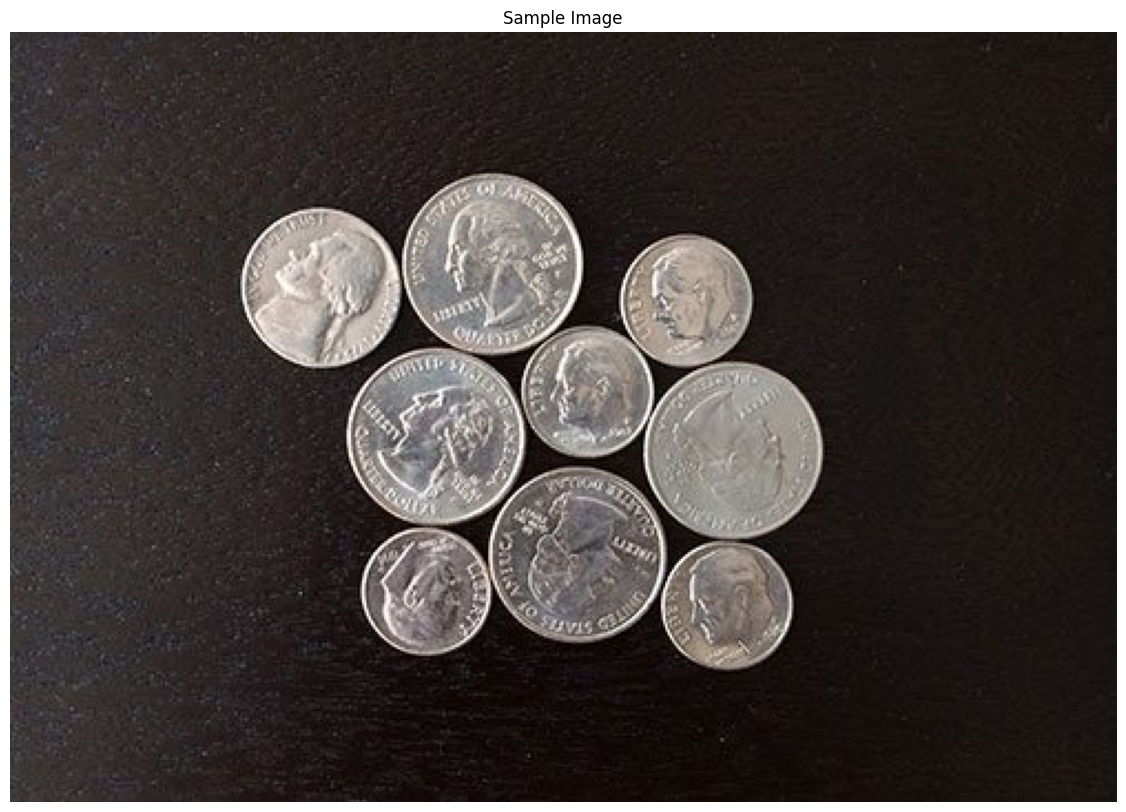

In [6]:
# Convert from BGR to RGB for display
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(sample_img_rgb)
plt.title('Sample Image')
plt.axis('off')
plt.show()

# Harris Corner Detection: Finding Stable Features in Images

## The Fundamental Challenge

Corners provide reliable landmarks to track across images or video frames.

Unlike edges (which are ambiguous along their length) or flat regions (which look the same everywhere), corners give us precise, unique locations that persist even under various transformations.

1. Find points where pixel brightness changes sharply in multiple directions
2. Calculate how much image changes horizontally and vertically around each pixel
3. Combine these measurements into a small matrix that describes local image behavior
4. Strong corners have significant change in all directions (like looking in all directions from a street corner)
5. Use simple mathematical shortcut to efficiently identify the strongest corners


## Mathematical Foundation with Intuitive Parallels

### Step 1: Understanding Local Image Structure

Consider how we humans identify corners: we notice regions where brightness changes sharply in different directions. We can formalize this intuition mathematically by examining gradients:

The image gradient at each pixel comprises two components:
- $I_x$: Measures intensity change in the horizontal direction
- $I_y$: Measures intensity change in the vertical direction


> **Reminder**: Gradients are a matrix

> **Reminder from last class**:
These gradients can be computed using simple convolution operations with derivative kernels (commonly Sobel or Prewitt operators). Think of these gradients as capturing the "slope" of the image intensity surface at each point.


## Step 2: The Structure Tensor

After computing image gradients, the next fundamental step in Harris Corner Detection is forming the structure tensor.

### What is the Structure Tensor?

The structure tensor (or second-moment matrix) is a 2×2 symmetric matrix that captures how intensity varies in all directions around a pixel. It's expressed as:

$$M = \sum_{(x,y) \in W} w(x,y) \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{bmatrix}$$

Where:
- $W$ is our local window (typically 3×3 to 7×7 pixels)
- $w(x,y)$ is a Gaussian weighting function giving higher importance to central pixels
- $I_x$ and $I_y$ are the image gradients at each pixel

### Interpretation of Matrix Elements

Each element in this matrix has a specific meaning:
- $I_x^2$: Measures intensity change in the horizontal direction
- $I_y^2$: Measures intensity change in the vertical direction
- $I_x I_y$: Captures correlated changes between horizontal and vertical directions

### Implementation in Practice

To implement this step:
1. Compute gradient products ($I_x^2$, $I_y^2$, and $I_x I_y$) at each pixel
2. Apply Gaussian smoothing to these product images
3. At each pixel, the smoothed values form the elements of matrix $M$

The Gaussian smoothing acts as the weighting function $w(x,y)$, effectively aggregating information from neighboring pixels with more weight given to closer pixels.

### Why This Matrix Matters

The structure tensor effectively captures the "shape" of local intensity changes:
- For flat regions: Both $I_x^2$ and $I_y^2$ are small, making $M$ close to zero
- For edges: One direction shows high change while the other doesn't
- For corners: Both directions show significant change

This matrix forms the mathematical foundation for distinguishing between these different image features, allowing us to reliably identify corners in the next steps of the algorithm.

### Connection to Image Structure

The structure tensor relates directly to how intensity varies in the image. Consider:
- At a horizontal edge: $I_y^2$ will be large but $I_x^2$ will be small
- At a vertical edge: $I_x^2$ will be large but $I_y^2$ will be small
- At a corner: Both $I_x^2$ and $I_y^2$ will be large

> *Question*: Is `M` always a 2x2 symmetric matrix  in Image Processing?

### Step 3: Eigenvalue Analysis – The Geometric Interpretation

The eigenvalues of matrix $M$ reveal the underlying structure of the local neighborhood:

Let's denote the eigenvalues as $\lambda_1$ and $\lambda_2$ (where $\lambda_1 \geq \lambda_2$):

- **Flat region**: $\lambda_1 \approx \lambda_2 \approx 0$ (minimal change in any direction)
- **Edge**: $\lambda_1 \gg \lambda_2 \approx 0$ (strong change along one direction only)
- **Corner**: $\lambda_1 \geq \lambda_2 \gg 0$ (significant change in multiple directions)

Visualize these eigenvalues as describing an ellipse. For corners, this ellipse approaches a circle with a large radius, indicating substantial variation in all directions.


## Physical Intuition: The "Shifting Window" Metaphor

Imagine placing a small window on the image and shifting it slightly in different directions:

- **Flat region**: The window contents barely change regardless of shift direction
- **Edge**: The window contents change significantly when shifting perpendicular to the edge, but not when shifting along it
- **Corner**: The window contents change substantially regardless of which direction you shift

The eigenvalues quantify these changes mathematically. When both eigenvalues are large, any direction you move the window results in significant change – this is precisely what defines a corner.

$$M = \begin{bmatrix} A & C \\ C & B \end{bmatrix}$$

Where:
- $A = \sum w(x,y) I_x^2$ (squared gradient in x-direction)
- $B = \sum w(x,y) I_y^2$ (squared gradient in y-direction)
- $C = \sum w(x,y) I_x I_y$ (product of gradients)

### Step 2: Find the eigenvalues of this 2×2 matrix

For a $2 \times 2$ matrix, we can find the eigenvalues by solving the characteristic equation:

$$\det(M - \lambda I) = 0$$

Where $I$ is the identity matrix and $\lambda$ represents the eigenvalues. Expanding this:

$$\det\begin{bmatrix} A - \lambda & C \\ C & B - \lambda \end{bmatrix} = 0$$

$$(A - \lambda)(B - \lambda) - C^2 = 0$$

This gives us a quadratic equation:

$$\lambda^2 - (A + B)\lambda + (AB - C^2) = 0$$

Using the quadratic formula, the eigenvalues are:

$$\lambda_{1,2} = \frac{(A + B) \pm \sqrt{(A - B)^2 + 4C^2}}{2}$$

In terms of the matrix properties, we can express this as:

$$\lambda_{1,2} = \frac{\text{trace}(M) \pm \sqrt{(\text{trace}(M))^2 - 4\det(M)}}{2}$$

Where:
- $\text{trace}(M) = A + B$ (sum of diagonal elements)
- $\det(M) = AB - C^2$ (determinant of the matrix)



### Step 4: The Harris Response Function – Computational Efficiency

Computing eigenvalues for every pixel is computationally expensive. Harris and Stephens introduced an efficient approximation:

$$R = \det(M) - k \cdot \text{trace}(M)^2 = \lambda_1\lambda_2 - k(\lambda_1 + \lambda_2)^2$$

Where:
- $\det(M) = \lambda_1\lambda_2$ represents the product of eigenvalues
- $\text{trace}(M) = \lambda_1 + \lambda_2$ represents their sum
- $k$ is an empirical constant (typically 0.04-0.06)

This response function $R$ effectively discriminates between different structures:
- $R \gg 0$: Indicates a corner (both eigenvalues are large)
- $R < 0$: Indicates an edge (one large, one small eigenvalue)
- $|R| \approx 0$: Indicates a flat region (both eigenvalues are small)

> **Now we don't need to compute the eigenvalues!**

## Implementation Considerations

1. **Scale sensitivity**: Corner detection depends on the size of your Gaussian window. Multiple scales may be necessary for robust detection.

2. **Non-maximum suppression**: After computing the response function, we suppress non-maximum values in local neighborhoods to ensure we identify the strongest corner candidates.

3. **Sub-pixel accuracy**: For higher precision applications, corner locations can be refined to sub-pixel accuracy using interpolation techniques.

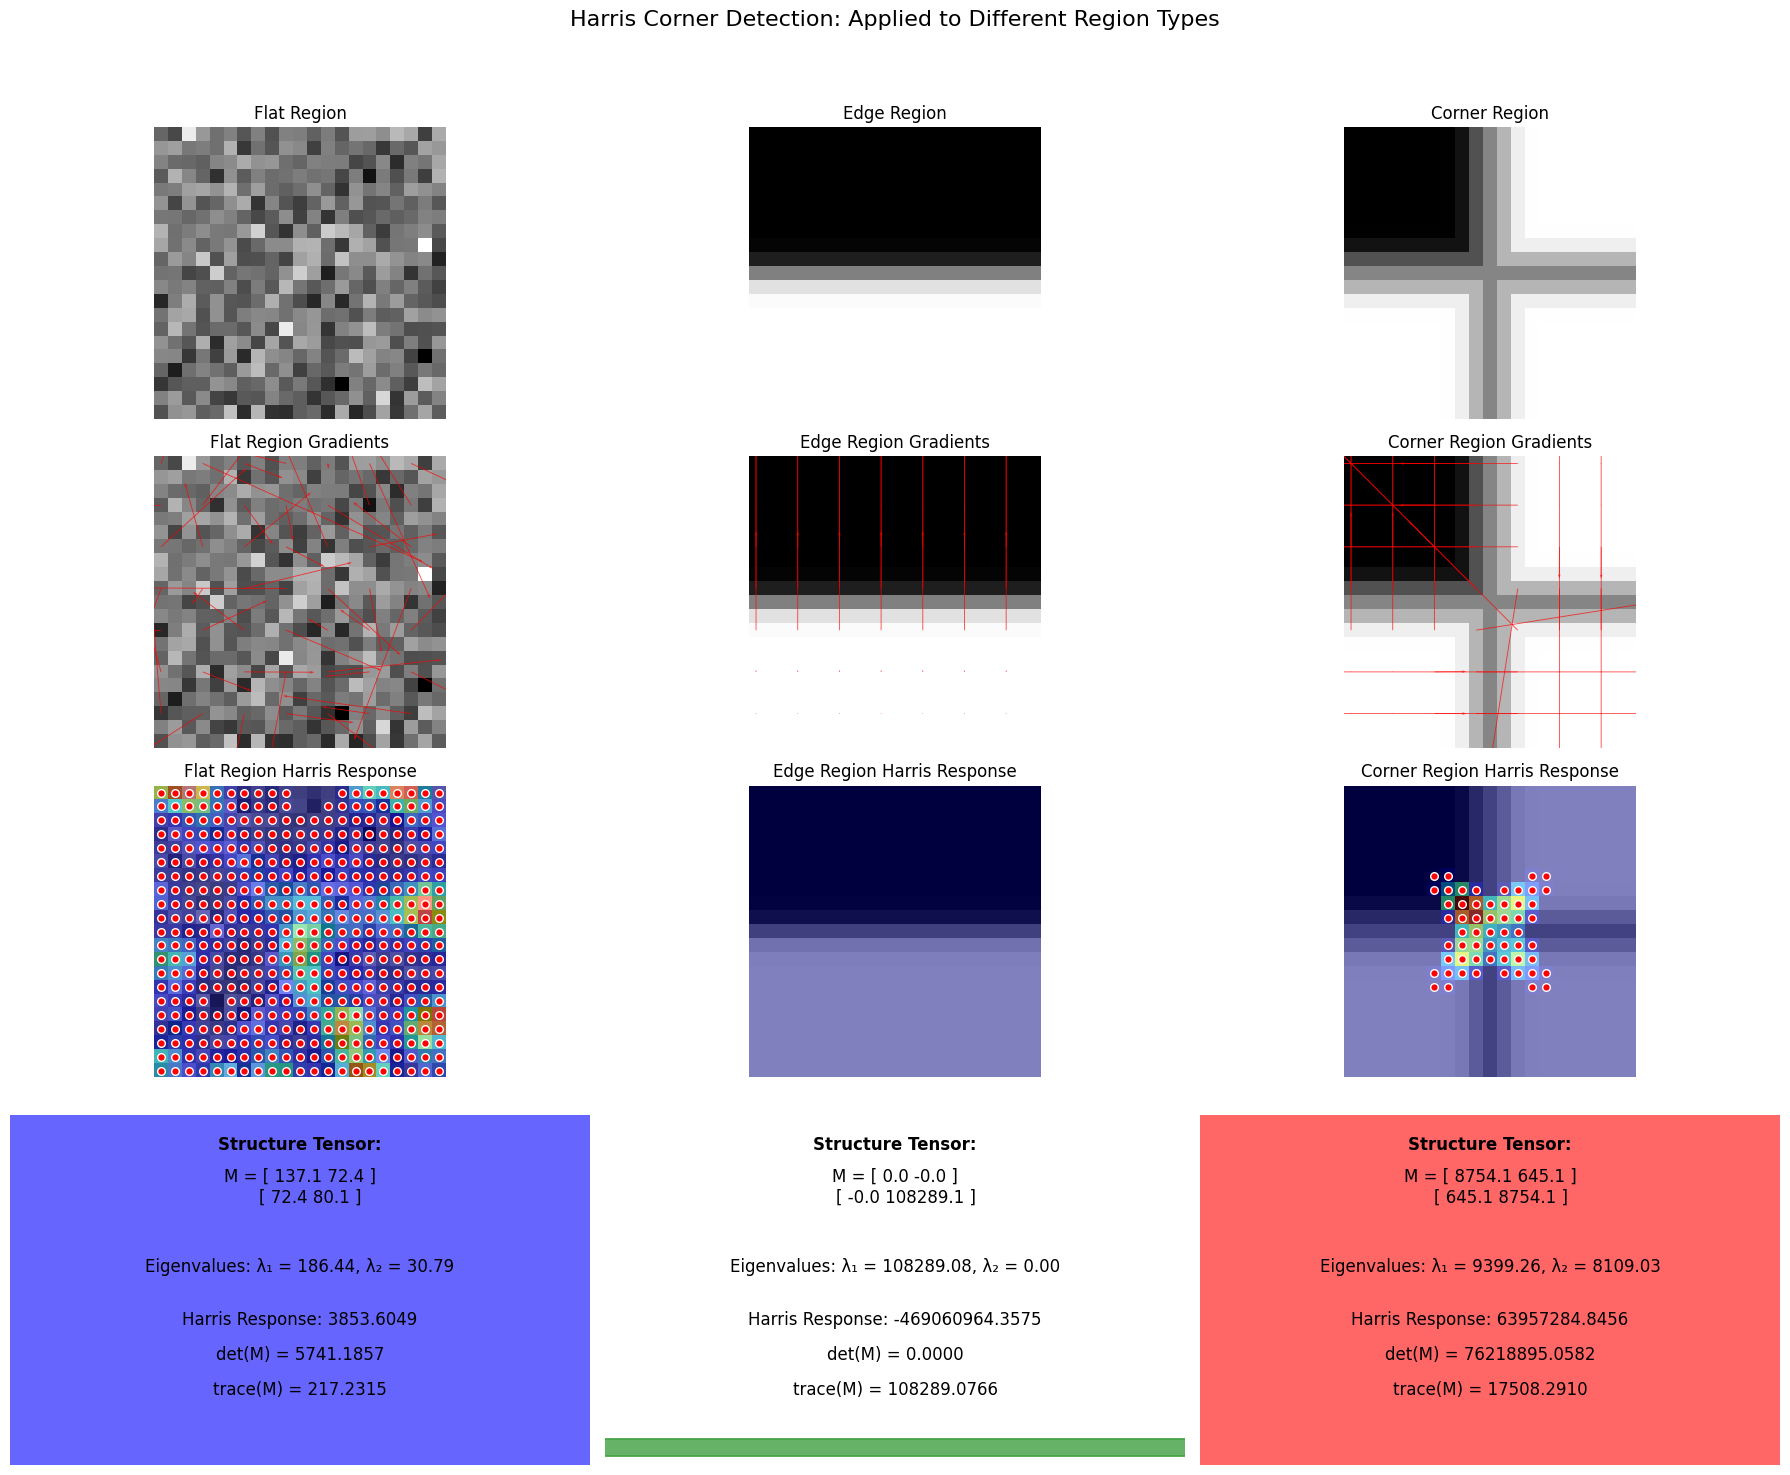

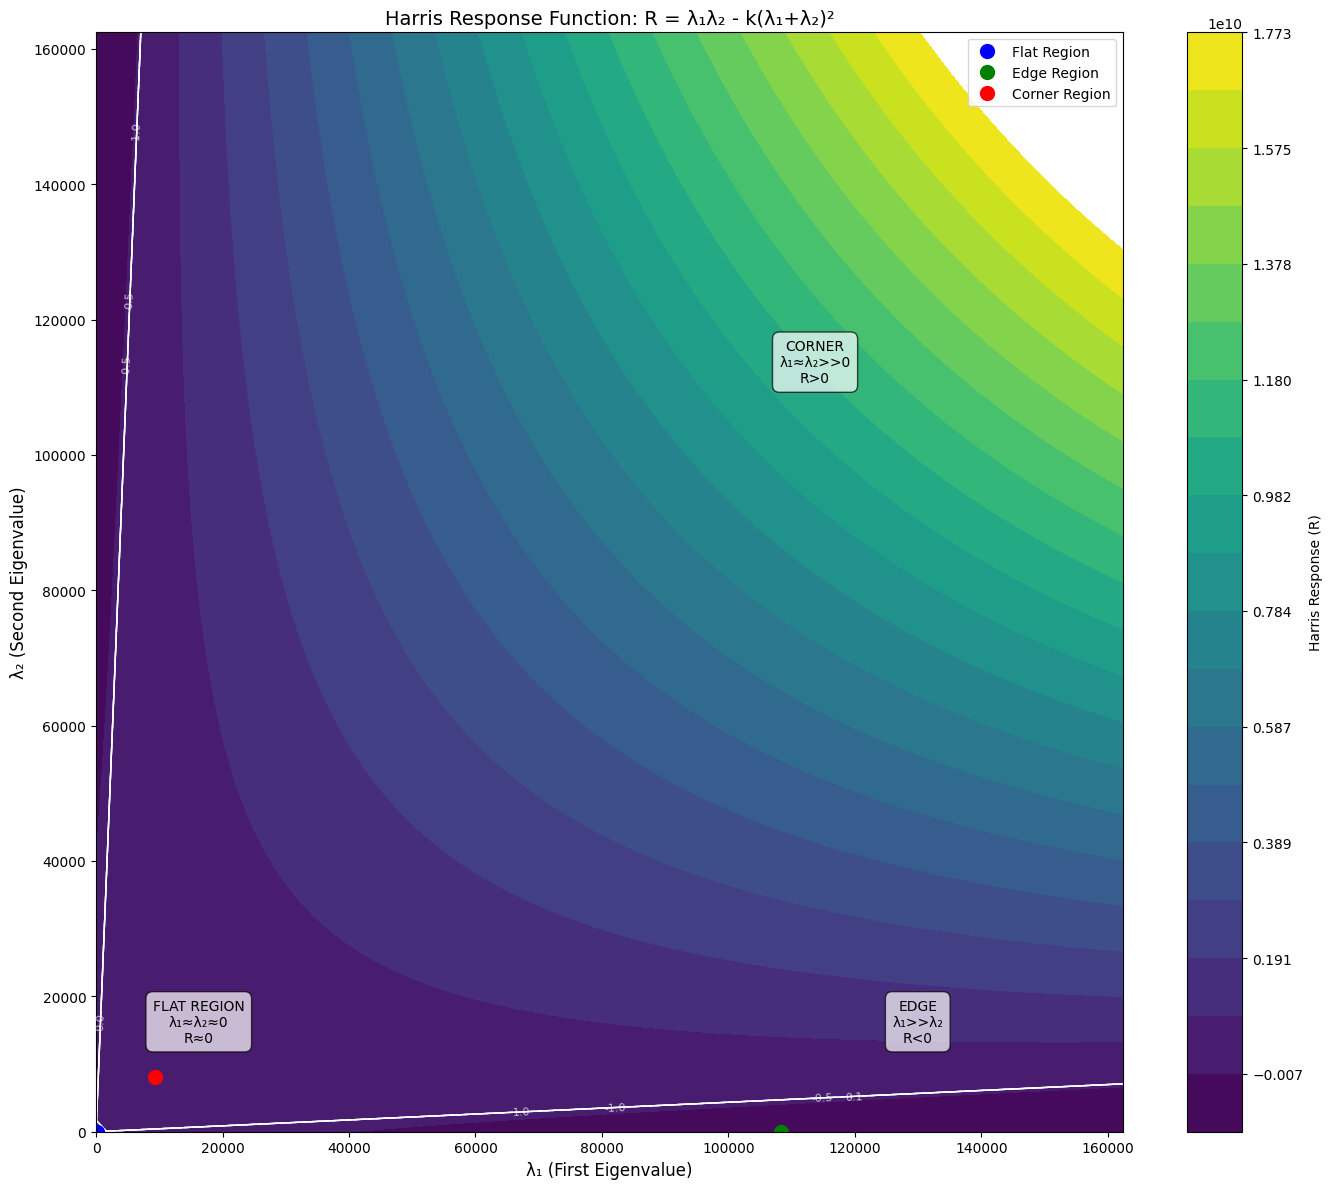

=== Flat Region Analysis (Center Point) ===
Structure Tensor M_flat:
[[137.1352852   72.40738836]
 [ 72.40738836  80.09620245]]
Eigenvalues: [186.43729694  30.79419071]
Harris Response: 3853.6049078572096
Number of corners detected: 435


=== Edge Region Analysis (Center Point) ===
Structure Tensor M_edge:
[[     0.             -0.        ]
 [    -0.         108289.07659103]]
Eigenvalues: [108289.07659103      0.        ]
Harris Response: -469060964.3575087
Number of corners detected: 0


=== Corner Region Analysis (Center Point) ===
Structure Tensor M_corner:
[[8754.14552248  645.11144036]
 [ 645.11144036 8754.14552248]]
Eigenvalues: [9399.25696284 8109.03408211]
Harris Response: 63957284.84559734
Number of corners detected: 57


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

def create_image_patches(size=21):
    """Create realistic image patches for demonstrating Harris corner detection"""
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    
    # Flat region: constant intensity with slight noise
    flat_region = np.ones((size, size)) * 128 + np.random.normal(0, 2, (size, size))
    
    # Edge region: clear horizontal edge with smooth transition
    sigma = 0.1  # Controls the sharpness of the edge
    edge_region = 128 + 70 * np.tanh(y / sigma)
    
    # Corner region: L-shaped corner with smooth transitions
    corner_mask = (x < 0) & (y < 0)
    corner_region = np.ones((size, size)) * 190
    corner_region[corner_mask] = 60
    # Add smooth transition at corner
    transition = 0.1
    distance = np.minimum(np.abs(x), np.abs(y))  # Distance to nearest axis
    corner_region = corner_region * (1 - np.exp(-distance**2 / (2 * transition**2))) + \
                   128 * np.exp(-distance**2 / (2 * transition**2))
    
    return flat_region, edge_region, corner_region

def harris_corner_detector(image, k=0.04, sigma=1.0, threshold=0.01):
    """Apply Harris corner detection algorithm to an image
    
    Args:
        image: Input grayscale image
        k: Harris detector free parameter (typically 0.04-0.06)
        sigma: Gaussian smoothing parameter
        threshold: Threshold for corner detection
        
    Returns:
        R: Harris response map
        corner_mask: Binary mask of detected corners
    """
    # Step 1: Compute image gradients
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    Ix = convolve2d(image, sobel_x, mode='same', boundary='symm')
    Iy = convolve2d(image, sobel_y, mode='same', boundary='symm')
    
    # Step 2: Compute products of gradients
    Ixx = Ix * Ix
    Ixy = Ix * Iy
    Iyy = Iy * Iy
    
    # Step 3: Gaussian smoothing of gradient products
    Ixx_smooth = gaussian_filter(Ixx, sigma=sigma)
    Ixy_smooth = gaussian_filter(Ixy, sigma=sigma)
    Iyy_smooth = gaussian_filter(Iyy, sigma=sigma)
    
    # Step 4: Compute Harris response for each pixel
    R = np.zeros_like(image, dtype=float)
    eigenvalues = np.zeros((image.shape[0], image.shape[1], 2))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Structure tensor at pixel (i,j)
            M = np.array([[Ixx_smooth[i, j], Ixy_smooth[i, j]],
                           [Ixy_smooth[i, j], Iyy_smooth[i, j]]])
            
            # Compute Harris response: det(M) - k * trace(M)^2
            det_M = np.linalg.det(M)
            trace_M = np.trace(M)
            R[i, j] = det_M - k * (trace_M ** 2)
            
            # Compute eigenvalues of M
            evals = np.linalg.eigvals(M)
            eigenvalues[i, j] = np.sort(evals)[::-1]  # Store in descending order (λ1 ≥ λ2)
    
    # Step 5: Threshold Harris response to find corners
    corner_mask = R > threshold * np.max(R)
    
    return R, corner_mask, eigenvalues, (Ix, Iy), (Ixx_smooth, Ixy_smooth, Iyy_smooth)

def plot_response_and_corners(ax, image, response, corners, title):
    """Plot Harris response with corner detections overlaid on the image"""
    ax.imshow(image, cmap='gray')
    
    # Overlay response as semi-transparent heatmap
    response_normalized = response / (np.max(np.abs(response)) + 1e-8)  # Avoid division by zero
    response_rgb = plt.cm.jet(response_normalized)
    response_rgb[..., 3] = 0.5  # Set alpha for transparency
    
    ax.imshow(response_rgb)
    
    # Plot detected corners
    y_idx, x_idx = np.where(corners)
    ax.scatter(x_idx, y_idx, s=30, marker='o', color='red', edgecolors='white')
    
    ax.set_title(title)
    ax.axis('off')

def plot_structure_tensor(ax, M, k, eigenvalues, response, color, scale_factor=0.2):
    """Plot structure tensor information with ellipse visualization"""
    ax.axis('off')
    ax.text(0.5, 0.9, "Structure Tensor:", ha='center', fontsize=12, fontweight='bold')
    
    # Simple matrix display that works without LaTeX issues
    ax.text(0.5, 0.75, 
            f"M = [ {M[0,0]:.1f} {M[0,1]:.1f} ]\n    [ {M[1,0]:.1f} {M[1,1]:.1f} ]",
            ha='center', fontsize=12)
    
    ax.text(0.5, 0.55, 
            f"Eigenvalues: λ₁ = {eigenvalues[0]:.2f}, λ₂ = {eigenvalues[1]:.2f}", 
            ha='center', fontsize=12)
    ax.text(0.5, 0.4, f"Harris Response: {response:.4f}", ha='center', fontsize=12)
    ax.text(0.5, 0.3, f"det(M) = {np.linalg.det(M):.4f}", ha='center', fontsize=12)
    ax.text(0.5, 0.2, f"trace(M) = {np.trace(M):.4f}", ha='center', fontsize=12)
    
    # Scale eigenvalues for better visualization
    width = max(eigenvalues[0] * scale_factor, 0.05)
    height = max(eigenvalues[1] * scale_factor, 0.05)
    
    # Add ellipse representing eigenvalue scaling
    ax.add_patch(Ellipse((0.5, 0.05), width=width, height=height,
                        alpha=0.6, color=color, fill=True))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

def plot_gradient_vectors(ax, image, Ix, Iy, title):
    """Plot gradient magnitude and direction visualization"""
    magnitude = np.sqrt(Ix**2 + Iy**2)
    # Normalize for visualization
    norm_magnitude = magnitude / np.max(magnitude) if np.max(magnitude) > 0 else magnitude
    
    # Only show arrows at subsampled points to avoid clutter
    step = 3
    y, x = np.mgrid[:Ix.shape[0]:step, :Ix.shape[1]:step]
    
    ax.imshow(image, cmap='gray')
    ax.quiver(x, y, Ix[::step, ::step], -Iy[::step, ::step], 
              color='red', scale=25, width=0.003, alpha=0.7)
    ax.set_title(title)
    ax.axis('off')

def plot_harris_contour(ax, eigen_ranges, points, k_value=0.04):
    """Plot the Harris response function contour with eigenvalue points"""
    # Create meshgrid for eigenvalue ranges
    lambda1 = np.linspace(0, eigen_ranges[0], 100)
    lambda2 = np.linspace(0, eigen_ranges[1], 100)
    Lambda1, Lambda2 = np.meshgrid(lambda1, lambda2)
    
    # Calculate Harris response
    R = Lambda1 * Lambda2 - k_value * (Lambda1 + Lambda2)**2
    
    # Create filled contour plot
    levels = np.linspace(np.min(R), np.max(R)*0.8, 20)
    contour = ax.contourf(Lambda1, Lambda2, R, levels=levels, cmap='viridis')
    plt.colorbar(contour, ax=ax, label='Harris Response (R)')
    
    # Add contour lines for clarity
    contour_lines = ax.contour(Lambda1, Lambda2, R, 
                               levels=[-1, -0.5, 0, 0.1, 0.5, 1], 
                               colors='white', linewidths=1, alpha=0.7)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.1f')
    
    # Add region labels
    x_max, y_max = eigen_ranges
    ax.text(0.1*x_max, 0.1*y_max, 'FLAT REGION\nλ₁≈λ₂≈0\nR≈0', 
           fontsize=10, ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    
    ax.text(0.8*x_max, 0.1*y_max, 'EDGE\nλ₁>>λ₂\nR<0', 
           fontsize=10, ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    
    ax.text(0.7*x_max, 0.7*y_max, 'CORNER\nλ₁≈λ₂>>0\nR>0', 
           fontsize=10, ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
    
    # Plot eigenvalue points
    colors = ['blue', 'green', 'red']
    labels = ['Flat Region', 'Edge Region', 'Corner Region']
    marker_size = 10
    
    for i, ((x, y), color, label) in enumerate(zip(points, colors, labels)):
        ax.plot(x, y, 'o', color=color, markersize=marker_size, label=label)
    
    ax.set_xlabel('λ₁ (First Eigenvalue)', fontsize=12)
    ax.set_ylabel('λ₂ (Second Eigenvalue)', fontsize=12)
    ax.set_title('Harris Response Function: R = λ₁λ₂ - k(λ₁+λ₂)²', fontsize=14)
    ax.legend(loc='upper right')

# Create the image patches
flat_region, edge_region, corner_region = create_image_patches()

# Apply Harris corner detection to each region
k_value = 0.04
flat_response, flat_corners, flat_eigenvalues, flat_gradients, flat_smoothed = harris_corner_detector(flat_region, k=k_value)
edge_response, edge_corners, edge_eigenvalues, edge_gradients, edge_smoothed = harris_corner_detector(edge_region, k=k_value)
corner_response, corner_corners, corner_eigenvalues, corner_gradients, corner_smoothed = harris_corner_detector(corner_region, k=k_value)

# Extract gradients
Ix_flat, Iy_flat = flat_gradients
Ix_edge, Iy_edge = edge_gradients
Ix_corner, Iy_corner = corner_gradients

# Get center point index (for detailed analysis of one point)
center = flat_region.shape[0] // 2

# Extract structure tensors at center points
M_flat = np.array([[flat_smoothed[0][center, center], flat_smoothed[1][center, center]],
                    [flat_smoothed[1][center, center], flat_smoothed[2][center, center]]])

M_edge = np.array([[edge_smoothed[0][center, center], edge_smoothed[1][center, center]],
                    [edge_smoothed[1][center, center], edge_smoothed[2][center, center]]])

M_corner = np.array([[corner_smoothed[0][center, center], corner_smoothed[1][center, center]],
                     [corner_smoothed[1][center, center], corner_smoothed[2][center, center]]])

# Get eigenvalues at center points (already computed above)
center_flat_eigenvalues = flat_eigenvalues[center, center]
center_edge_eigenvalues = edge_eigenvalues[center, center]
center_corner_eigenvalues = corner_eigenvalues[center, center]

# Get Harris responses at center points
center_flat_response = flat_response[center, center]
center_edge_response = edge_response[center, center]
center_corner_response = corner_response[center, center]

# Set up the figure
plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 1.2])

# Display image patches
ax1 = plt.subplot(gs[0, 0])
ax1.imshow(flat_region, cmap='gray')
ax1.set_title('Flat Region')
ax1.axis('off')

ax2 = plt.subplot(gs[0, 1])
ax2.imshow(edge_region, cmap='gray')
ax2.set_title('Edge Region')
ax2.axis('off')

ax3 = plt.subplot(gs[0, 2])
ax3.imshow(corner_region, cmap='gray')
ax3.set_title('Corner Region')
ax3.axis('off')

# Display gradient visualizations
ax4 = plt.subplot(gs[1, 0])
plot_gradient_vectors(ax4, flat_region, Ix_flat, Iy_flat, 'Flat Region Gradients')

ax5 = plt.subplot(gs[1, 1])
plot_gradient_vectors(ax5, edge_region, Ix_edge, Iy_edge, 'Edge Region Gradients')

ax6 = plt.subplot(gs[1, 2])
plot_gradient_vectors(ax6, corner_region, Ix_corner, Iy_corner, 'Corner Region Gradients')

# Display Harris response plots
ax7 = plt.subplot(gs[2, 0])
plot_response_and_corners(ax7, flat_region, flat_response, flat_corners, 'Flat Region Harris Response')

ax8 = plt.subplot(gs[2, 1])
plot_response_and_corners(ax8, edge_region, edge_response, edge_corners, 'Edge Region Harris Response')

ax9 = plt.subplot(gs[2, 2])
plot_response_and_corners(ax9, corner_region, corner_response, corner_corners, 'Corner Region Harris Response')

# Plot structure tensor info
ax10 = plt.subplot(gs[3, 0])
plot_structure_tensor(ax10, M_flat, k_value, center_flat_eigenvalues, center_flat_response, color='blue')

ax11 = plt.subplot(gs[3, 1])
plot_structure_tensor(ax11, M_edge, k_value, center_edge_eigenvalues, center_edge_response, color='green')

ax12 = plt.subplot(gs[3, 2])
plot_structure_tensor(ax12, M_corner, k_value, center_corner_eigenvalues, center_corner_response, color='red')

plt.suptitle('Harris Corner Detection: Applied to Different Region Types', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create second figure for Harris response contour
fig2 = plt.figure(figsize=(14, 12))

# Find maximum eigenvalue for scaling the plot
max_eigen_values = [np.max(center_flat_eigenvalues), 
                    np.max(center_edge_eigenvalues), 
                    np.max(center_corner_eigenvalues)]
max_eigen = max(max_eigen_values) * 1.5

# Points to plot on contour (center point eigenvalues)
eigenvalue_points = [
    (center_flat_eigenvalues[0], center_flat_eigenvalues[1]),
    (center_edge_eigenvalues[0], center_edge_eigenvalues[1]),
    (center_corner_eigenvalues[0], center_corner_eigenvalues[1])
]

# Plot Harris response contour
ax_contour = fig2.add_subplot(1, 1, 1)
plot_harris_contour(ax_contour, (max_eigen, max_eigen), eigenvalue_points, k_value)

plt.tight_layout()
plt.show()

# Print detailed information about each region
print("=== Flat Region Analysis (Center Point) ===")
print(f"Structure Tensor M_flat:\n{M_flat}")
print(f"Eigenvalues: {center_flat_eigenvalues}")
print(f"Harris Response: {center_flat_response}")
print(f"Number of corners detected: {np.sum(flat_corners)}")
print("\n")

print("=== Edge Region Analysis (Center Point) ===")
print(f"Structure Tensor M_edge:\n{M_edge}")
print(f"Eigenvalues: {center_edge_eigenvalues}")
print(f"Harris Response: {center_edge_response}")
print(f"Number of corners detected: {np.sum(edge_corners)}")
print("\n")

print("=== Corner Region Analysis (Center Point) ===")
print(f"Structure Tensor M_corner:\n{M_corner}")
print(f"Eigenvalues: {center_corner_eigenvalues}")
print(f"Harris Response: {center_corner_response}")
print(f"Number of corners detected: {np.sum(corner_corners)}")

## Do you notice any problems from the application above and below?!

In [8]:
sample_img = cv2.imread('images/road.jpg')
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
# Convert to grayscale
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)


In [9]:
cv2.cornerHarris?

Docstring:
cornerHarris(src, blockSize, ksize, k[, dst[, borderType]]) -> dst
.   @brief Harris corner detector.
.   
.   The function runs the Harris corner detector on the image. Similarly to cornerMinEigenVal and
.   cornerEigenValsAndVecs , for each pixel \f$(x, y)\f$ it calculates a \f$2\times2\f$ gradient covariance
.   matrix \f$M^{(x,y)}\f$ over a \f$\texttt{blockSize} \times \texttt{blockSize}\f$ neighborhood. Then, it
.   computes the following characteristic:
.   
.   \f[\texttt{dst} (x,y) =  \mathrm{det} M^{(x,y)} - k  \cdot \left ( \mathrm{tr} M^{(x,y)} \right )^2\f]
.   
.   Corners in the image can be found as the local maxima of this response map.
.   
.   @param src Input single-channel 8-bit or floating-point image.
.   @param dst Image to store the Harris detector responses. It has the type CV_32FC1 and the same
.   size as src .
.   @param blockSize Neighborhood size (see the details on #cornerEigenValsAndVecs ).
.   @param ksize Aperture parameter for the Sobel ope

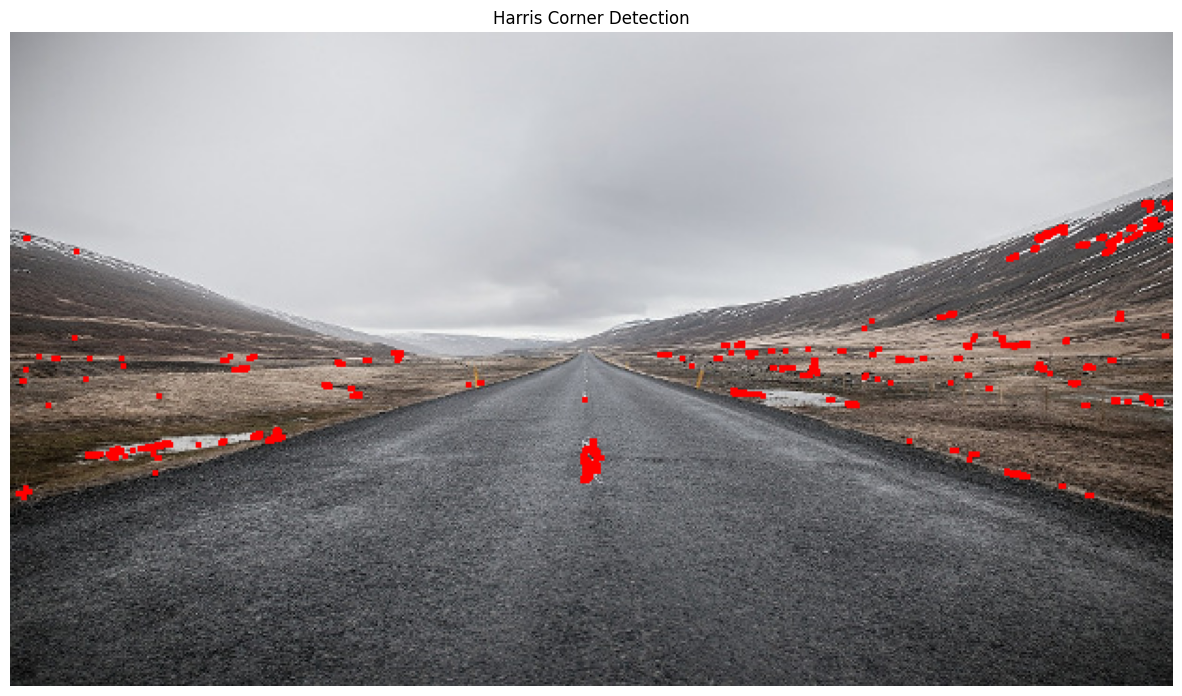

Number of Harris corners detected: 2520


In [17]:

# Implement Harris corner detector
gray = np.float32(gray)
harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=11, k=0.04)

# Dilate corner detections for better visibility
dilated_corners = cv2.dilate(harris_corners, None)

# Create a copy of the original image for display
harris_img = sample_img_rgb.copy()

# Define threshold for corner detection
threshold = 0.01 * dilated_corners.max()

# Mark corners on the image
harris_img[dilated_corners > threshold] = [255, 0, 0]  # Red color for corners

# Display the result
plt.imshow(harris_img)
plt.title('Harris Corner Detection')
plt.axis('off')
plt.show()

print(f"Number of Harris corners detected: {np.sum(dilated_corners > threshold)}")

The Harris corner detector classifies image points into three categories:
- **Flat regions**: No change in intensity in any direction (both eigenvalues are small)
- **Edges**: Significant change in one direction only (one eigenvalue is large, one is small)
- **Corners**: Significant change in multiple directions (both eigenvalues are large)

**Common Pitfalls:**
- Not scale-invariant: Performance varies with image scale
- Parameter tuning: The blockSize, ksize, and k parameters need careful adjustment
- Limited rotation invariance


### 2.2 Shi-Tomasi Corner Detector


The Shi-Tomasi detector was actually introduced in their 1994 paper on feature tracking. It's particularly well-suited for tracking applications because:

1. Corners where both eigenvalues are large tend to be more stable under small image transformations
2. The minimum eigenvalue directly relates to how well a feature point can be tracked

When a feature point has a small eigenvalue in one direction, small changes in that direction can be hard to detect reliably, making the point less suitable for tracking.



**Harris Corner Detector:**
- Response function: $R = \det(M) - k \cdot \text{trace}^2(M)$
- Expanded: $R = \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2$

**Shi-Tomasi Corner Detector:**
- Response function: $R = \min(\lambda_1, \lambda_2)$


Imagine we plot points on a graph where the x-axis is $\lambda_1$ and the y-axis is $\lambda_2$:

1. **Flat regions:** Both eigenvalues are small → point near origin
2. **Edge regions:** One eigenvalue large, one small → point near one of the axes
3. **Corner regions:** Both eigenvalues large → point far from both axes

The Harris detector creates a curved decision boundary through this space with its equation. The Shi-Tomasi detector, however, creates a much simpler boundary: it simply asks "are both eigenvalues above some threshold?"

This is more directly aligned with the fundamental property of corners: strength of gradient in multiple directions.



In [19]:
cv2.goodFeaturesToTrack?

Docstring:
goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance[, corners[, mask[, blockSize[, useHarrisDetector[, k]]]]]) -> corners
.   @brief Determines strong corners on an image.
.   
.   The function finds the most prominent corners in the image or in the specified image region, as
.   described in @cite Shi94
.   
.   -   Function calculates the corner quality measure at every source image pixel using the
.       #cornerMinEigenVal or #cornerHarris .
.   -   Function performs a non-maximum suppression (the local maximums in *3 x 3* neighborhood are
.       retained).
.   -   The corners with the minimal eigenvalue less than
.       \f$\texttt{qualityLevel} \cdot \max_{x,y} qualityMeasureMap(x,y)\f$ are rejected.
.   -   The remaining corners are sorted by the quality measure in the descending order.
.   -   Function throws away each corner for which there is a stronger corner at a distance less than
.       maxDistance.
.   
.   The function can be used to initialize

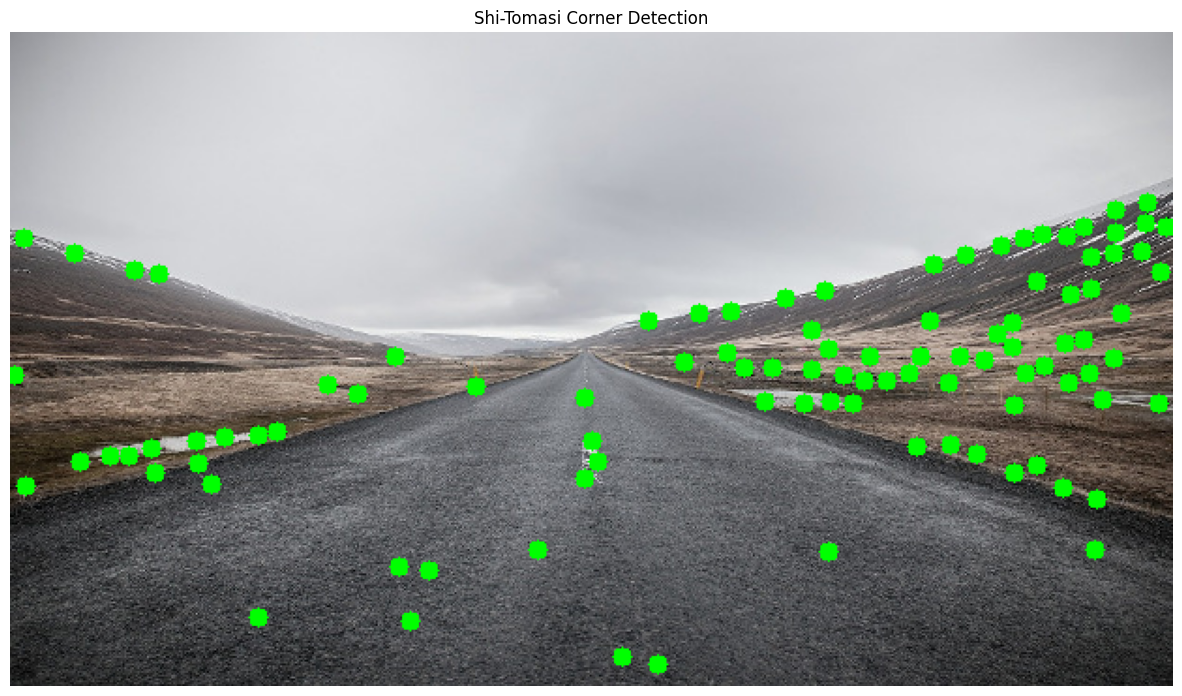

Number of Shi-Tomasi corners detected: 100


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image and convert to RGB and grayscale
sample_img = cv2.imread('images/road.jpg')
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

# Implement Shi-Tomasi corner detector
corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
if corners is not None:
    corners = corners.astype(int)  # Convert to integer type

    # Create a copy of the original image for display
    shi_tomasi_img = sample_img_rgb.copy()

    # Mark corners on the image
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(shi_tomasi_img, (x, y), 5, (0, 255, 0), -1)  # Green circles for corners

    # Display the result
    plt.imshow(shi_tomasi_img)
    plt.title('Shi-Tomasi Corner Detection')
    plt.axis('off')
    plt.show()

    print(f"Number of Shi-Tomasi corners detected: {len(corners)}")
else:
    print("No corners detected.")


## Summary of Shi Tomasi

1. Creates a more intuitive measure of "cornerness"
2. Eliminates the need for a sensitivity parameter
3. Produces corner points that are more stable for tracking
4. Aligns more directly with the mathematical theory of feature tracking




**COMMON PITFALLS: Shi-Tomasi vs. Harris**

The Shi-Tomasi detector generally performs better than Harris because:
- It directly uses the eigenvalues, which have a more intuitive physical meaning
- The minimum eigenvalue is a more reliable measure of corner strength
- It provides better stability for tracking applications

However, it still lacks scale invariance like Harris.


# FAST Corner Detection Explained

## Core Concept
- Detects corners by examining intensity patterns in a circular arrangement around pixels
- Designed for computational efficiency in real-time applications

## How It Works

1. **Setup:**
   - Consider pixel p with intensity Ip
   - Set threshold t (typically 20-40)
   - Examine 16 pixels in a circle (radius 3) around p

2. **Detection Rule:**
   - Pixel p is a corner if n contiguous pixels on the circle are:
     - ALL brighter than (Ip + t) OR
     - ALL darker than (Ip - t)
   - Standard setting: n = 12 pixels

3. **Speed Optimization:**
   - First test only pixels 1, 5, 9, 13 (at compass points)
   - If at least 3 of these 4 fail the test, immediately reject p
   - Eliminates ~70% of candidates with minimal computation

## Visual Representation
```
     1  2  3
  16        4
15            5
14            6
13            7
  12       8
     11 10 9
```

## Why It Detects Corners
- Flat regions: pixels around circle have similar values to center
- Edges: values form two semi-circles of different intensities
- Corners: abrupt changes in intensity around different segments of the circle

## Advantages
- Extremely fast computation
- Simple to implement
- Good repeatability
- Minimal resource requirements

## Limitations
- Not scale invariant
- No corner strength measure in basic version
- Sensitive to noise
- Often produces multiple responses around a single corner

## Practical Improvements
- FAST-ER: Machine learning optimized version
- Non-maximum suppression: Removes duplicate detections
- Variable n: Using n=9 (more corners) or n=14 (fewer, stronger corners)
- Adaptive thresholds: Adjusts t based on local image statistics

## Applications
- Real-time SLAM
- Augmented reality
- Mobile vision applications
- Feature tracking in video
- Robotics

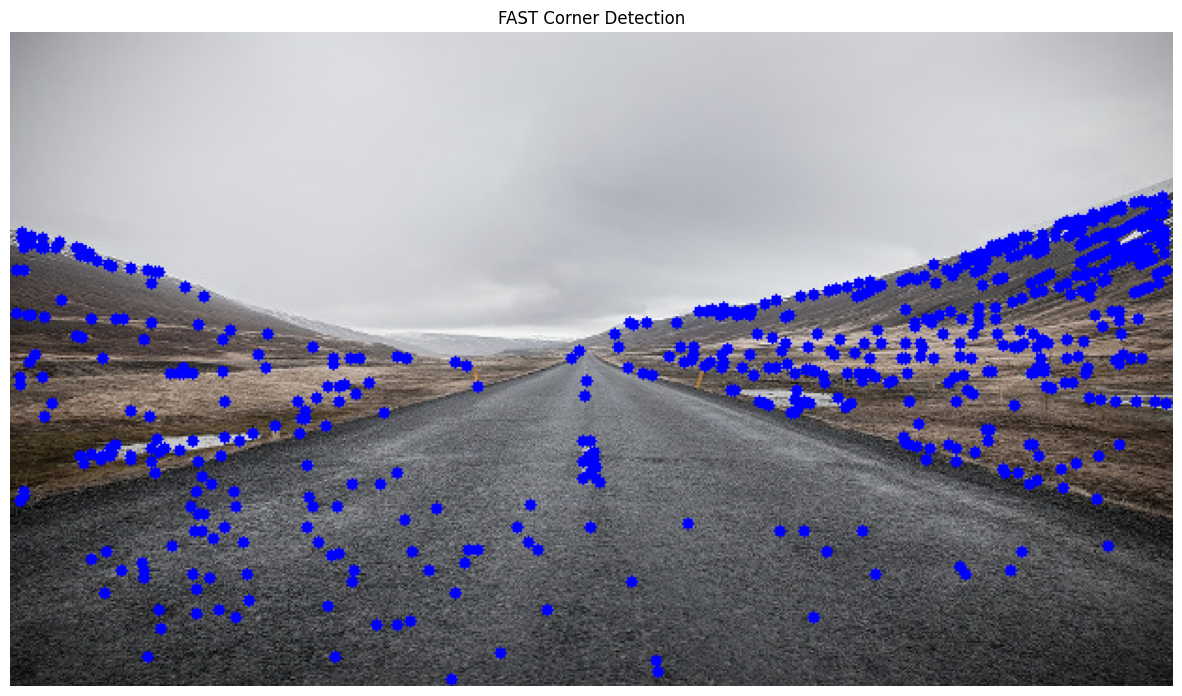

Number of FAST corners detected: 589


In [20]:
# Implement FAST corner detector
fast = cv2.FastFeatureDetector_create(threshold=50)
fast_corners = fast.detect(gray, None)

# Create a copy of the original image for display
fast_img = sample_img_rgb.copy()

# Mark corners on the image
for corner in fast_corners:
    x, y = corner.pt
    cv2.circle(fast_img, (int(x), int(y)), 3, (0, 0, 255), -1)  # Blue circles for corners

# Display the result
plt.imshow(fast_img)
plt.title('FAST Corner Detection')
plt.axis('off')
plt.show()

print(f"Number of FAST corners detected: {len(fast_corners)}")

**INTUITION CHECK: FAST Detector**

FAST is optimized for speed, making it suitable for real-time applications:
- Much faster than Harris and Shi-Tomasi
- Less computationally intensive
- Good for applications like SLAM (Simultaneous Localization and Mapping)

**Limitations:**
- Not scale or rotation invariant
- More sensitive to noise
- Doesn't provide a measure of corner strength
- May detect multiple corners around a single true corner


Let's compare the performance and characteristics of these corner detectors.

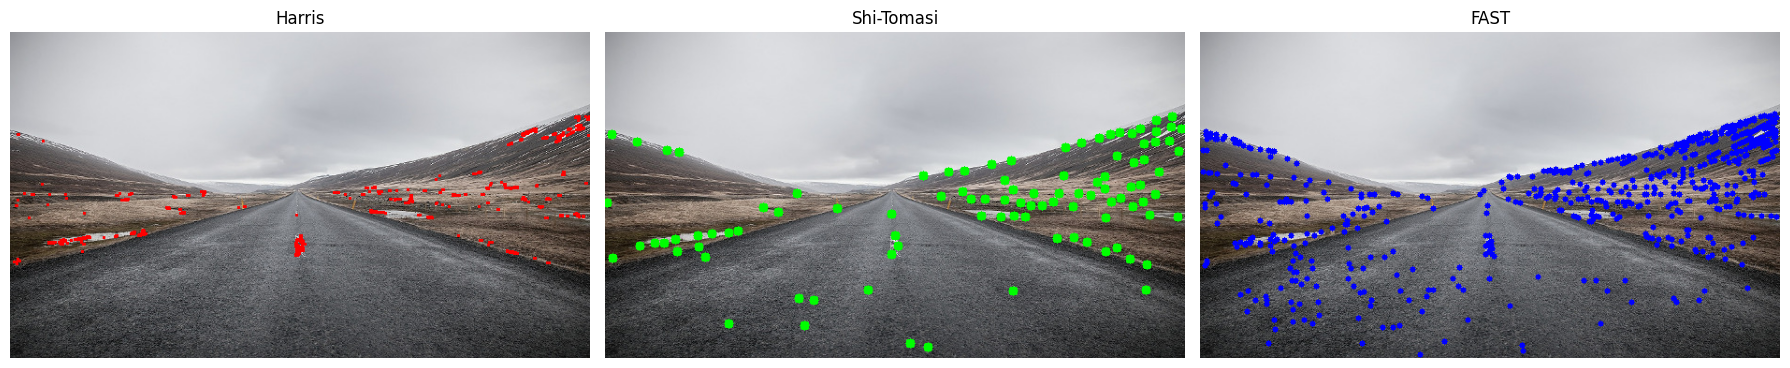

In [21]:
### 2.4 Algorithm Comparison

# Create a side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(harris_img)
axes[0].set_title('Harris')
axes[0].axis('off')

axes[1].imshow(shi_tomasi_img)
axes[1].set_title('Shi-Tomasi')
axes[1].axis('off')

axes[2].imshow(fast_img)
axes[2].set_title('FAST')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### ORB’s Improvements Over Basic Detectors

ORB enhances FAST and BRIEF by adding orientation awareness and robustness:

**1. Keypoint Detection (via FAST):**  
ORB begins by detecting corner points using the FAST algorithm, which is efficient and fast.

**2. Orientation Assignment:**  
To achieve rotation invariance, ORB computes the orientation of each keypoint using the intensity centroid method.  
It calculates image moments within a local patch to estimate the dominant direction around the keypoint.

**3. Descriptor Computation (Modified BRIEF):**  
ORB generates a 256-bit binary descriptor by:

- Sampling 256 pairs of pixels around the keypoint.
- Comparing their intensities:
  - If the first pixel is brighter → record a `1`
  - Otherwise → record a `0`
- This results in a compact, binary descriptor.

**4. Rotation Invariance (Key Improvement):**  
Unlike standard BRIEF, ORB rotates the pixel pairs according to the keypoint’s orientation before computing the descriptor, making it robust to image rotation.

The descriptor doesn’t describe in a human-readable way — instead, it encodes *local appearance* in a compact, binary format that's easy to compare.

### How it works:

- Each `0` or `1` captures the result of a simple intensity comparison between two pixels near a keypoint.
- The **pattern of 0s and 1s** across all 256 pairs reflects **texture, edges, corners, or flatness** in that patch — but indirectly.
- Similar-looking patches will produce **similar binary patterns**.

### Why it's useful:

- You can compare descriptors using **Hamming distance** (just count how many bits differ).
- This makes matching very fast and efficient for large image datasets.

So, it’s less about *interpreting* the descriptor, and more about using it for **fast and reliable matching** between keypoints.

While a feature detector like Harris or FAST tells us **where** interesting points are.

A Descriptor tells us **what** these points look like in a way that computers can compare

### 3.2 Feature Matching between images

Once we have descriptors, we can match features across images using:
- Brute-Force Matching
- FLANN (Fast Library for Approximate Nearest Neighbors)

### Feature Matching

1. **Brute Force Matching**: Compares each descriptor in the first image against all descriptors in the second image, finding the closest match based on Hamming distance.

2. **FLANN Matching**: Uses Fast Library for Approximate Nearest Neighbors to efficiently match features, followed by a ratio test to filter out ambiguous matches.

### Enabling Higher-Level Vision Tasks

Feature matching is the foundation for numerous applications:

- **Image alignment**: Determining how two images relate spatially
- **Object recognition**: Identifying the same object across different views
- **3D reconstruction**: Building 3D models by understanding how points correspond across multiple images
- **Motion tracking**: Following objects as they move through a video sequence
- **Simultaneous Localization and Mapping (SLAM)**: Allowing robots to build maps while tracking their position

### Quantifying Feature Quality

The matching process reveals how well our feature detectors and descriptors actually perform. A good detector should find features that:

1. Are distinctive enough to match correctly
2. Remain stable across transformations (scale, rotation, viewpoint)
3. Can be described accurately by the descriptor algorithm

### The Role of Feature Descriptors

While Harris, Shi-Tomasi, and FAST tell us where keypoints are, they don't provide descriptors (numerical fingerprints of the feature). ORB adds the crucial descriptor component that enables matching.

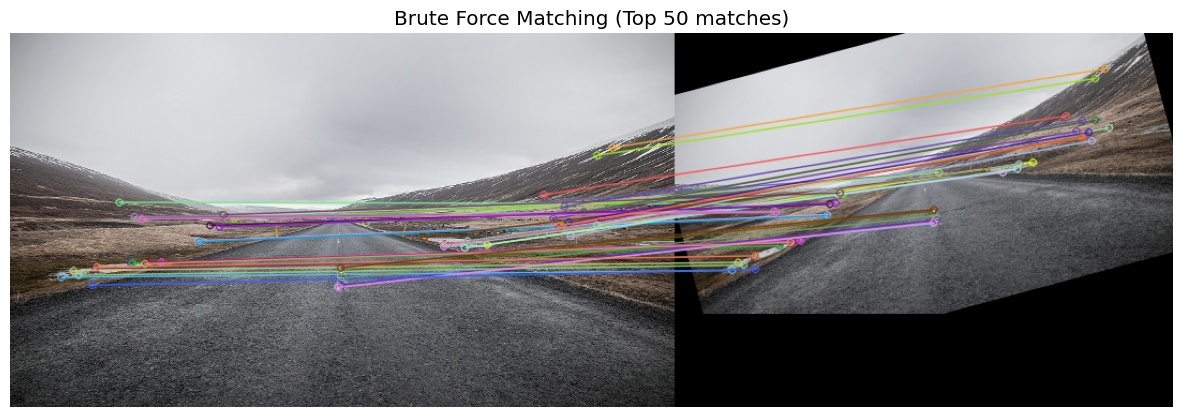

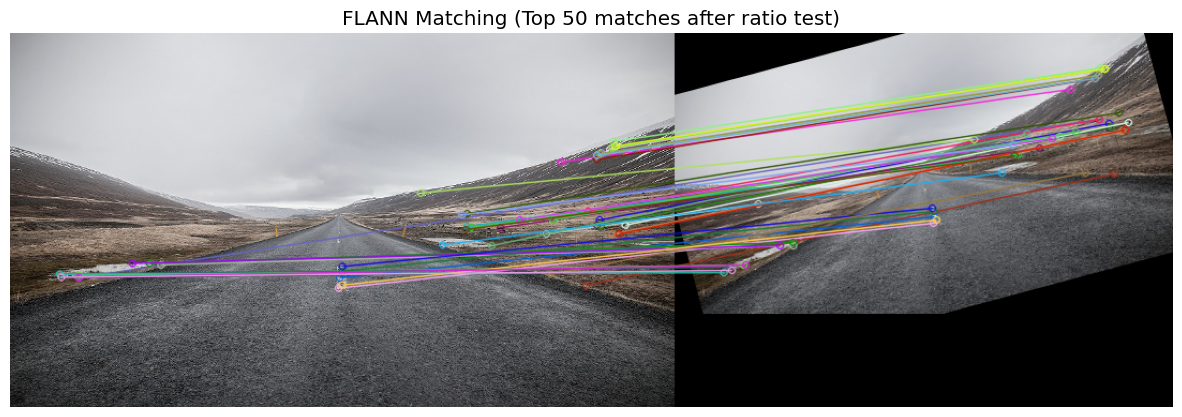

Number of Brute Force matches: 182
Number of FLANN good matches: 129


In [91]:
# Brute Force Matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
bf_matches_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, 
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(bf_matches_img)
plt.title('Brute Force Matching (Top 50 matches)')
plt.axis('off')
plt.show()

# FLANN Matching
# FLANN parameters for ORB
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=6,
                    key_size=12,
                    multi_probe_level=1)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
flann_matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
good_matches = []
for match_pair in flann_matches:
    if len(match_pair) == 2:
        m, n = match_pair
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

# Draw top matches
flann_matches_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches[:50], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(flann_matches_img)
plt.title('FLANN Matching (Top 50 matches after ratio test)')
plt.axis('off')
plt.show()

print(f"Number of Brute Force matches: {len(matches)}")
print(f"Number of FLANN good matches: {len(good_matches)}")

## Feature Matching Techniques**

**Brute Force Matching**:
- Compares each descriptor in the first set with all descriptors in the second set
- Simple but computationally expensive for large feature sets
- Works well for small images or when the number of features is limited

**FLANN Matching**:
- Approximates the nearest neighbor search, making it much faster
- Better for large datasets
- Requires parameter tuning based on the descriptor type

**Ratio Test** (Lowe's ratio test):
- Filters out ambiguous matches by comparing the distances of the two best matches
- If the ratio of distances is below a threshold (typically 0.7-0.8), the match is considered reliable
- Significantly improves matching quality

### 3.3 Improving Matches with RANSAC (outlier detection)

Let's use RANSAC to remove outliers from our matches.

Think of RANSAC like a detective trying to uncover the true story among conflicting witness accounts.


Outliers are random — they don't agree with each other.  
Inliers (correct matches) all **agree on the same transformation**.

By repeatedly sampling and measuring agreement, RANSAC finds the underlying pattern, even when the data is noisy or partially wrong.



## How It Works (Step-by-Step)

1. **Pick a random sample**  
   Select a few feature matches (e.g., 4 point pairs).

2. **Estimate a model**  
   Use those matches to compute a transformation (e.g., homography or affine).

3. **Test the model**  
   Check how many of the *other* matches agree with this transformation (i.e., are close after applying it).

4. **Repeat**  
   Try many random samples and keep track of which one gets the most “votes.”

5. **Choose the best**  
   The model with the highest consensus is likely the correct one.


In [7]:
# Filter matches with RANSAC
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Convert mask to boolean array
    matchesMask = mask.ravel().tolist()
    
    # Draw only inliers
    ransac_matches_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None,
                                       matchColor=(0, 255, 0),
                                       singlePointColor=None,
                                       matchesMask=matchesMask,
                                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(ransac_matches_img)
    plt.title('Matches after RANSAC filtering')
    plt.axis('off')
    plt.show()
    
    inliers = sum(matchesMask)
    print(f"Number of inliers after RANSAC: {inliers} ({inliers/len(good_matches)*100:.2f}% of good matches)")

NameError: name 'good_matches' is not defined

**COMMON PITFALLS: Feature Matching**

1. **Poor Feature Quality**: If features aren't distinctive or robust, matching will fail
   - Solution: Choose appropriate feature detectors and descriptors for your application

2. **Threshold Selection**: Too strict thresholds result in few matches; too loose thresholds give many false matches
   - Solution: Experiment with different thresholds and use techniques like RANSAC to filter matches

3. **Descriptor Type Mismatch**: Using the wrong distance metric for the descriptor type
   - Solution: Use Hamming distance for binary descriptors (ORB, BRIEF) and L2 distance for float descriptors (SIFT, SURF)

4. **Extreme Transformations**: Large changes in scale, rotation, or viewpoint can cause matching failure
   - Solution: Use scale and rotation invariant features like SIFT or SURF for challenging scenarios

5. **Illumination Changes**: Significant lighting changes can affect descriptors
   - Solution: Use descriptors that normalize for illumination, or preprocess images to equalize lighting

- **Always use filtering techniques like**:
  - Ratio test for removing ambiguous matches
  - RANSAC for removing geometric outliers

## 4. Face Detection with OpenCV and Haar Cascades

### 4.1 Understanding Haar Cascades

Haar Cascade classifiers use machine learning to detect objects in images. They're trained on positive and negative examples and use Haar-like features to identify patterns.


**Haar Cascade Classifiers**

**How Haar Cascades Work:**
1. Calculate Haar-like features (differences between adjacent rectangular regions)
2. Use a cascade of classifiers to reject non-face regions quickly
3. If a region passes all stages, it's classified as a face

**Advantages:**
- Fast detection once trained
- Good for real-time applications
- Works well for frontal faces in good lighting
- Built into OpenCV with pre-trained models

**Limitations:**
- Less robust to variations in pose, occlusion, and lighting
- Higher false positive rate compared to modern deep learning approaches
- Requires multiple passes at different scales
- Poor performance on rotated or tilted faces

Haar Cascade classifiers use **AdaBoost** (Adaptive Boosting) during training.

### Details:
- **AdaBoost** selects the most informative Haar features from a large pool.
- It combines many weak classifiers (each based on a single Haar feature) into a strong classifier.
- Each stage in the cascade is trained with AdaBoost to focus on minimizing false negatives while keeping false positives low.

So, the optimization is done via **AdaBoost's iterative reweighting**, which focuses more on the examples that were misclassified in previous rounds.

### 4.2 Implementing Face Detection

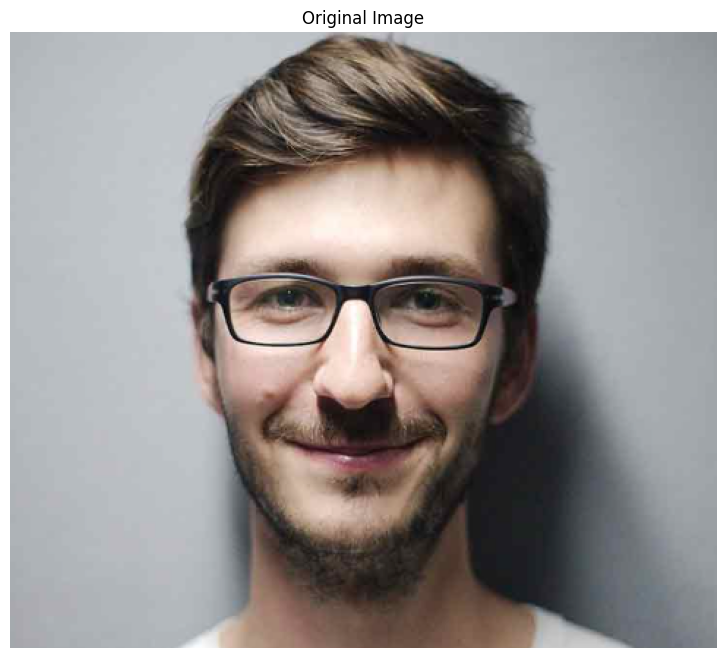

In [8]:

# Load a sample image with faces
face_img = cv2.imread('images/face1.png')

# Convert to RGB for display
face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(face_img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()


Found 1 faces!


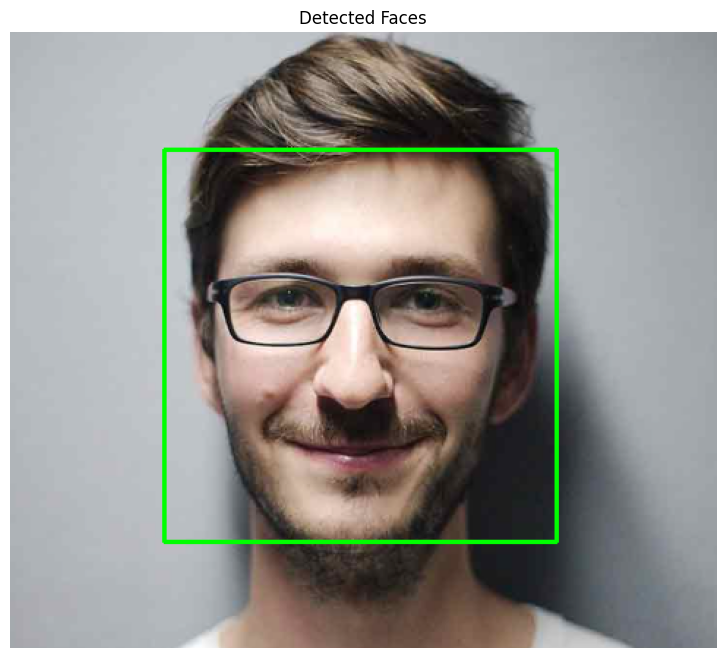

In [9]:
# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert to grayscale (required for Haar Cascade)
gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags=cv2.CASCADE_SCALE_IMAGE
)

print(f"Found {len(faces)} faces!")

# Draw rectangles around detected faces
faces_detected = face_img_rgb.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(faces_detected, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(faces_detected)
plt.title('Detected Faces')
plt.axis('off')
plt.show()

**Key Parameters in Face Detection**

The `detectMultiScale` function has several important parameters:

- **scaleFactor**: Specifies how much the image size is reduced at each scale. A value of 1.1 means reducing size by 10% at each scale.
  - Smaller values (closer to 1) provide better detection but are slower
  - Larger values are faster but might miss faces

- **minNeighbors**: Specifies how many neighbors each candidate rectangle should have to be considered a face.
  - Higher values result in fewer detections but with higher quality
  - Lower values result in more detections, including more false positives

- **minSize**: Minimum possible face size. Faces smaller than this are ignored.
  - Adjust based on expected face sizes in your images
  - Smaller sizes allow detecting distant faces but increase processing time

### 4.3 Handling Detection Challenges

Let's explore some common challenges in face detection.

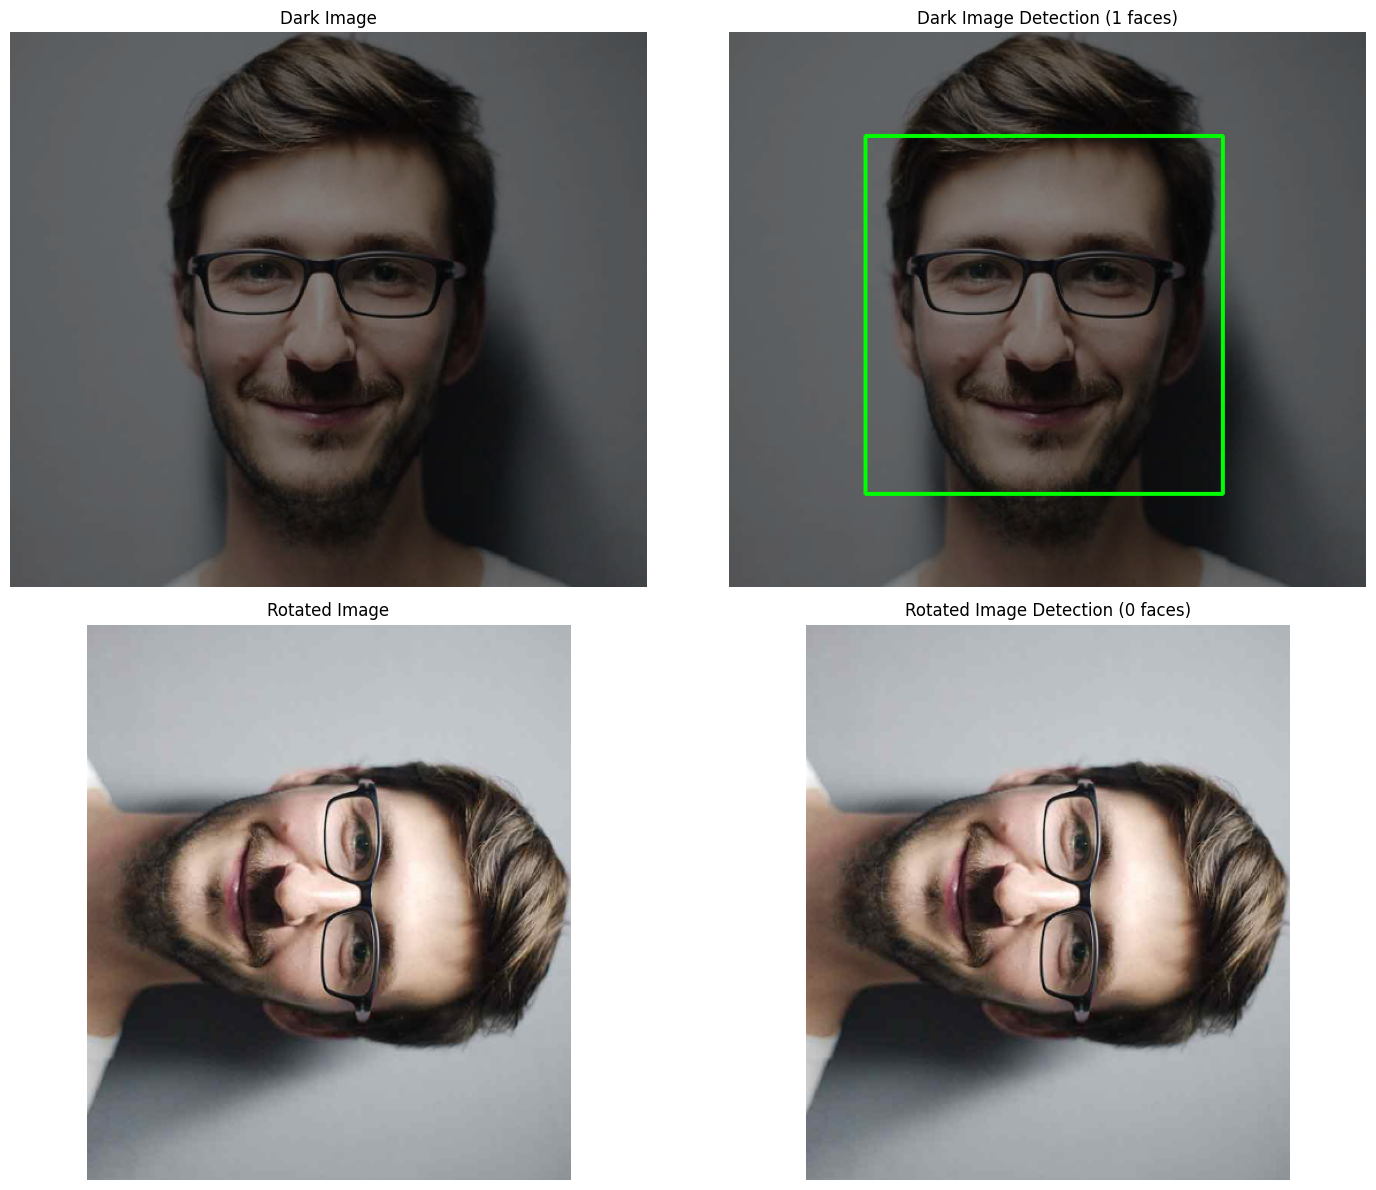

In [10]:
# Create a challenging scenario with different angles and lighting
def simulate_challenges(image):
    # Create copies for different transformations
    brightness = cv2.convertScaleAbs(image, alpha=0.5, beta=0)  # Darker
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)  # Rotated
    return brightness, rotated

# Apply transformations
dark_img, rotated_img = simulate_challenges(face_img)

# Convert to RGB for display
dark_img_rgb = cv2.cvtColor(dark_img, cv2.COLOR_BGR2RGB)
rotated_img_rgb = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB)

# Run face detection on challenging scenarios
faces_dark = face_cascade.detectMultiScale(
    cv2.cvtColor(dark_img, cv2.COLOR_BGR2GRAY),
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)

faces_rotated = face_cascade.detectMultiScale(
    cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY),
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)

# Draw detections
dark_detected = dark_img_rgb.copy()
for (x, y, w, h) in faces_dark:
    cv2.rectangle(dark_detected, (x, y), (x+w, y+h), (0, 255, 0), 2)

rotated_detected = rotated_img_rgb.copy()
for (x, y, w, h) in faces_rotated:
    cv2.rectangle(rotated_detected, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(dark_img_rgb)
axes[0, 0].set_title('Dark Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(dark_detected)
axes[0, 1].set_title(f'Dark Image Detection ({len(faces_dark)} faces)')
axes[0, 1].axis('off')

axes[1, 0].imshow(rotated_img_rgb)
axes[1, 0].set_title('Rotated Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_detected)
axes[1, 1].set_title(f'Rotated Image Detection ({len(faces_rotated)} faces)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


**COMMON CHALLENGES: Face Detection**

1. **Lighting Variations**: Uneven lighting, shadows, or extreme brightness/darkness
   - Solution: Histogram equalization, adaptive thresholding
   
2. **Pose Variations**: Tilted or rotated faces, side views
   - Solution: Multiple detectors for different angles or deep learning approaches
   
3. **Occlusions**: Glasses, beards, masks, partial faces
   - Solution: Part-based detectors or deep learning models
   
4. **Scale Variations**: Very small or large faces in the image
   - Solution: Multi-scale detection, proper tuning of scaleFactor
   
5. **False Positives**: Non-face regions detected as faces
   - Solution: Increase minNeighbors, post-processing validation

### 4.4 Improving Detection with Preprocessing

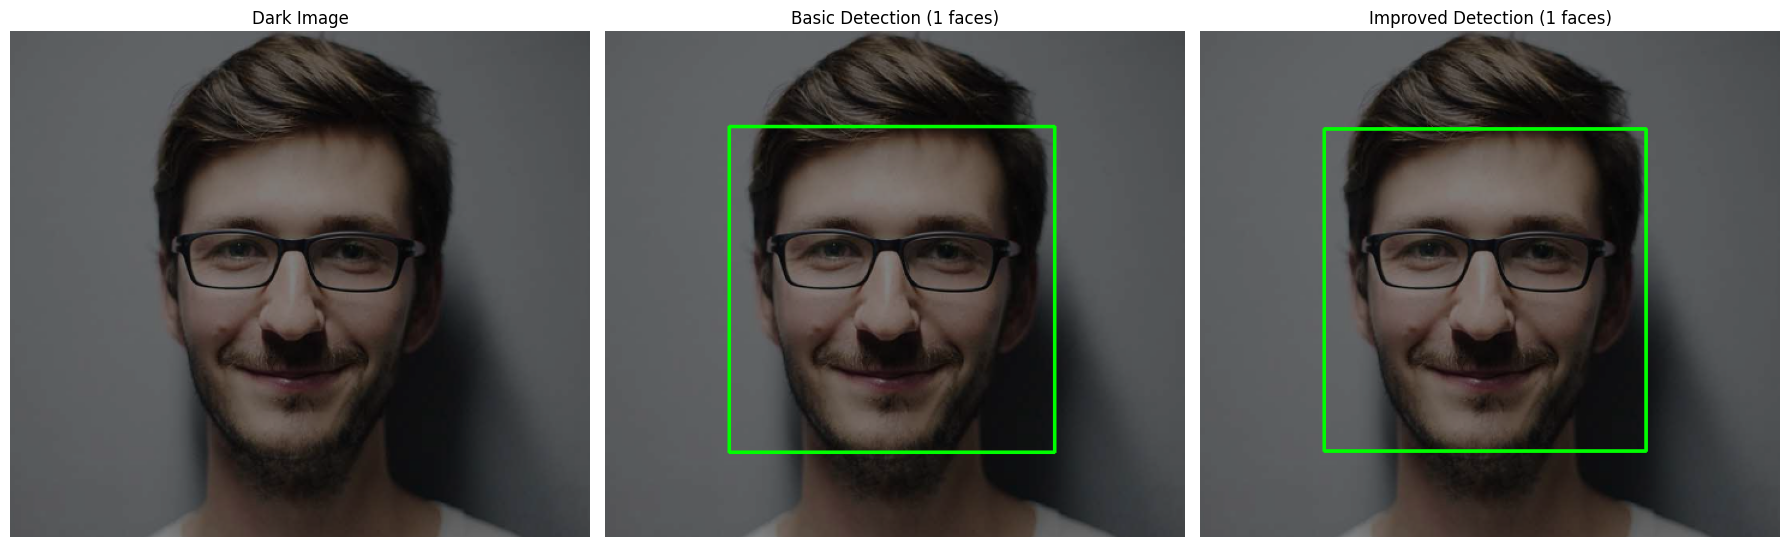

In [11]:
# Preprocess for better detection
def preprocess_for_detection(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    
    return blurred

# Preprocess and detect
preprocessed_dark = preprocess_for_detection(dark_img)
faces_dark_improved = face_cascade.detectMultiScale(
    preprocessed_dark,
    scaleFactor=1.05,  # More fine-grained scaling
    minNeighbors=3,    # More permissive
    minSize=(20, 20)   # Smaller minimum size
)

# Draw improved detections
dark_detected_improved = dark_img_rgb.copy()
for (x, y, w, h) in faces_dark_improved:
    cv2.rectangle(dark_detected_improved, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(dark_img_rgb)
axes[0].set_title('Dark Image')
axes[0].axis('off')

axes[1].imshow(dark_detected)
axes[1].set_title(f'Basic Detection ({len(faces_dark)} faces)')
axes[1].axis('off')

axes[2].imshow(dark_detected_improved)
axes[2].set_title(f'Improved Detection ({len(faces_dark_improved)} faces)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

**INTUITION CHECK: Face Detection Methods**

- **Use Haar Cascades when**:
  - Computational resources are limited
  - Real-time processing is needed on devices with limited power
  - Detecting primarily frontal faces in controlled environments
  - Quick prototyping or simple applications

- **Consider Deep Learning approaches (like SSD, YOLO, or RetinaFace) when**:
  - Higher accuracy is needed
  - Detecting faces in varied poses, lighting, and occlusions
  - GPU resources are available
  - The application requires state-of-the-art performance

## 5. Facial Landmark Detection

### 5.1 What are Facial Landmarks?

Facial landmarks are key points on a face that define the shape of facial features like eyes, eyebrows, nose, mouth, and jawline.

**Facial Landmarks**

Facial landmarks are key points that map the shape and features of a face. Common landmark models include:

- **5-point model**: Eyes, nose tip, and mouth corners
- **68-point model**: More detailed mapping including jawline, eyebrows, eyes, nose, and mouth
- **194-point model**: Very detailed mapping used in specialized applications

These landmarks allow us to:
- Precisely locate facial features
- Analyze facial expressions
- Align faces for recognition
- Create face meshes for 3D reconstruction

### 5.2 Detecting Facial Landmarks

We'll use a simplified approach to demonstrate facial landmarks:

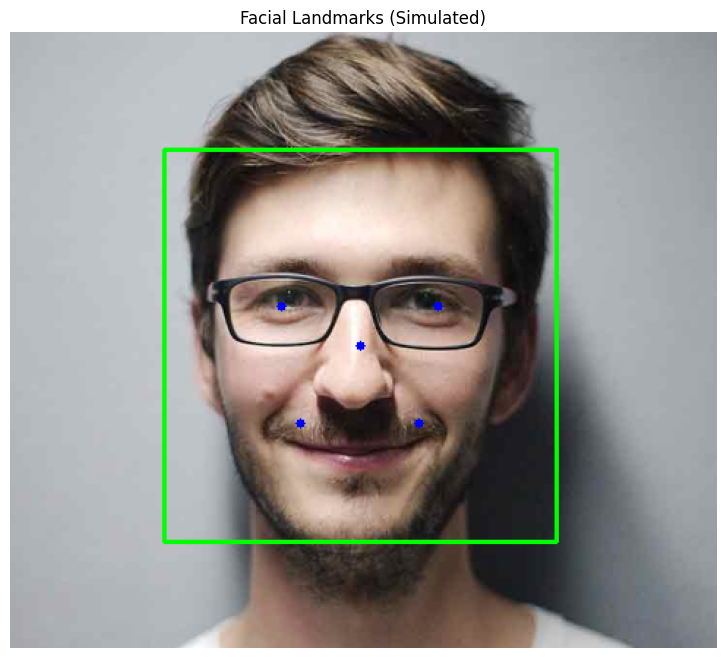

In [12]:
# Function to get facial landmarks
def get_landmarks(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    
    landmarks_list = []
    
    # For demonstration, we'll use a simplified approach
    # In a real application, you would use dlib's facial landmark detector
    for (x, y, w, h) in faces:
        # Simulate landmarks for demonstration
        # In practice, use: predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        # followed by landmarks = predictor(gray, dlib.rectangle(x, y, x+w, y+h))
        
        # Simulate eye landmarks
        left_eye_x, left_eye_y = x + int(w * 0.3), y + int(h * 0.4)
        right_eye_x, right_eye_y = x + int(w * 0.7), y + int(h * 0.4)
        
        # Simulate nose landmark
        nose_x, nose_y = x + int(w * 0.5), y + int(h * 0.5)
        
        # Simulate mouth landmarks
        mouth_left_x, mouth_left_y = x + int(w * 0.35), y + int(h * 0.7)
        mouth_right_x, mouth_right_y = x + int(w * 0.65), y + int(h * 0.7)
        
        landmarks = [
            (left_eye_x, left_eye_y),
            (right_eye_x, right_eye_y),
            (nose_x, nose_y),
            (mouth_left_x, mouth_left_y),
            (mouth_right_x, mouth_right_y)
        ]
        
        landmarks_list.append((faces[0], landmarks))
    
    return landmarks_list

# Get landmarks for our original face image
landmarks_results = get_landmarks(face_img)

# Draw landmarks on the image
landmark_img = face_img_rgb.copy()

for (face_rect, landmarks) in landmarks_results:
    (x, y, w, h) = face_rect
    
    # Draw face rectangle
    cv2.rectangle(landmark_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Draw landmarks
    for (lx, ly) in landmarks:
        cv2.circle(landmark_img, (lx, ly), 3, (0, 0, 255), -1)

# Display result
plt.figure(figsize=(10, 8))
plt.imshow(landmark_img)
plt.title('Facial Landmarks (Simulated)')
plt.axis('off')
plt.show()

In [13]:
import os
import bz2
import urllib.request

# Create a directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Define the URL and file paths
model_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
compressed_model_path = "models/shape_predictor_68_face_landmarks.dat.bz2"
model_path = "shape_predictor_68_face_landmarks.dat"

# Download the compressed model if it doesn't exist
if not os.path.exists(model_path):
    print("Downloading facial landmark predictor model...")
    urllib.request.urlretrieve(model_url, compressed_model_path)
    
    # Extract the compressed file
    print("Extracting compressed model file...")
    with bz2.BZ2File(compressed_model_path) as input_file, open(model_path, 'wb') as output_file:
        output_file.write(input_file.read())
    
    print(f"Model saved to {model_path}")

In [14]:
image = face_img

In [ ]:
import dlib

# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Convert dlib's rectangle to OpenCV style
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

# Convert landmark prediction to numpy array
def shape_to_np(shape):
    landmarks = np.zeros((68, 2), dtype=int)
    for i in range(0, 68):
        landmarks[i] = (shape.part(i).x, shape.part(i).y)
    return landmarks

In [18]:
# Detect faces using dlib
detector = dlib.get_frontal_face_detector()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)

In [ ]:
# Process each face
for rect in rects:
    # Get landmarks
    shape = predictor(gray, rect)
    landmarks = shape_to_np(shape)
    
    # Draw landmarks
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 2, (0, 0, 255), -1)

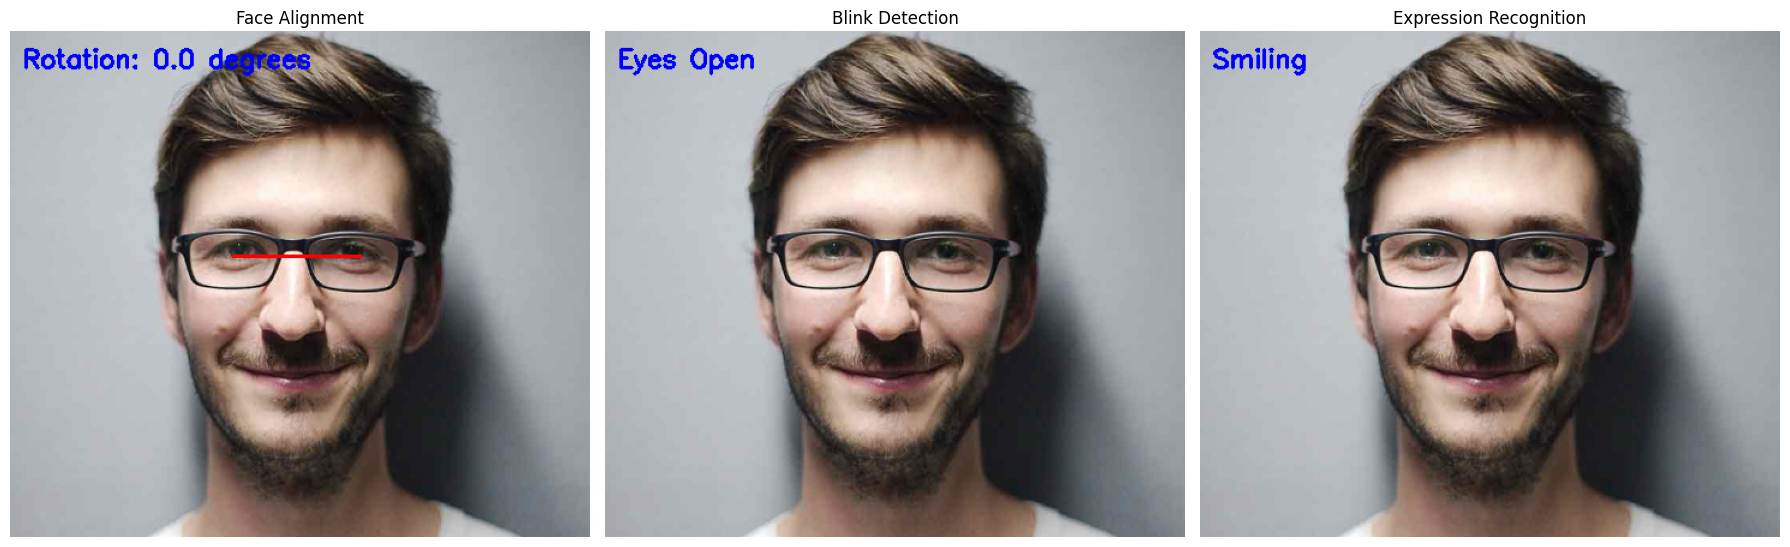

In [17]:
def demonstrate_landmark_applications(image, face_rect, landmarks):
    (x, y, w, h) = face_rect
    
    # Create copies for different applications
    face_alignment = image.copy()
    blink_detection = image.copy()
    expression = image.copy()
    
    # 1. Face alignment (simplified illustration)
    cv2.line(face_alignment, landmarks[0], landmarks[1], (255, 0, 0), 2)  # Eye line
    angle = np.degrees(np.arctan2(landmarks[1][1] - landmarks[0][1], 
                                 landmarks[1][0] - landmarks[0][0]))
    cv2.putText(face_alignment, f"Rotation: {angle:.1f} degrees", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # 2. Blink detection (simplified)
    eye_aspect_ratio = 0.3  # Simulated value
    blink_text = "Blinking" if eye_aspect_ratio < 0.2 else "Eyes Open"
    cv2.putText(blink_detection, blink_text, 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # 3. Expression recognition (simplified)
    mouth_width = np.sqrt((landmarks[4][0] - landmarks[3][0])**2 + 
                         (landmarks[4][1] - landmarks[3][1])**2)
    expression_text = "Smiling" if mouth_width > w * 0.3 else "Neutral"
    cv2.putText(expression, expression_text, 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    return face_alignment, blink_detection, expression

# Apply to our image
if landmarks_results:
    face_rect, landmarks = landmarks_results[0]
    alignment, blink, expression = demonstrate_landmark_applications(face_img_rgb, face_rect, landmarks)
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(alignment)
    axes[0].set_title('Face Alignment')
    axes[0].axis('off')
    
    axes[1].imshow(blink)
    axes[1].set_title('Blink Detection')
    axes[1].axis('off')
    
    axes[2].imshow(expression)
    axes[2].set_title('Expression Recognition')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

**Applications of Facial Landmarks**

1. **Face Alignment**:
   - Normalizing faces to a canonical pose
   - Essential preprocessing for face recognition
   - Uses eye centers to calculate rotation angle

2. **Eye State Analysis**:
   - Blink detection (using eye aspect ratio)
   - Gaze tracking
   - Drowsiness detection

3. **Expression Recognition**:
   - Smile detection
   - Emotion classification
   - Action unit analysis

4. **Face Morphing and Animation**:
   - Facial motion capture
   - AR filters and effects
   - Face swapping

5. **Biometric Applications**:
   - Face verification/recognition
   - Age and gender estimation
   - Identity-preserving transformations